# Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

from astropy.io import fits
from scipy.ndimage import median_filter
from scipy.signal import correlate, find_peaks
from numpy.polynomial.polynomial import Polynomial
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift as nd_shift 
from scipy.signal import savgol_filter

# Image Functions

In [61]:
def load_fits_2d(path: str) -> np.ndarray:
    with fits.open(path) as hdul:
        data = hdul[0].data
    data = np.squeeze(data).astype(np.float32)
    if data.ndim != 2:
        raise ValueError(f"{path}: erwartet 2D, bekam shape {data.shape}")
    return data

def moving_average(x_sample, delta):
    N_elements_to_check = 2*delta+1
    length = len(x_sample)
    x_average = x_sample.copy()
    
    #Normale Werte
    for n in range(delta, length-delta):
        x_average[n] = sum(x_sample[n-delta:n+delta])/N_elements_to_check

    #Randwerte
    for n in range(delta):
        #Anfang
        x_average[n] = sum(x_sample[:n+delta])/(n+delta)
        #Ende
        x_average[length-delta + n] = sum(x_sample[length - delta -n:length])/(delta+n)

    return x_average

def extract_1d_spectrum(data2d: np.ndarray, half_height: int = 20, bg_offset: int = 50, bg_half: int = 10, filtering = True, normalize = True, delta = 10):
    """
    - findet y0 über Summe entlang x (Spurmaximum)
    - extrahiert Summe im Fenster [y0-half_height, y0+half_height]
    - zieht Hintergrund ab (aus zwei Off-Trace Fenstern)
    """
    ny, nx = data2d.shape

    # Spurposition schätzen
    y_profile = np.sum(data2d, axis=1)
    y0 = int(np.argmax(y_profile))

    y1 = max(0, y0 - half_height)
    y2 = min(ny, y0 + half_height + 1)

    # Hintergrundfenster ober-/unterhalb
    yb1a = ny - bg_offset - bg_half # lower Window beginning
    yb1b = ny - bg_offset + bg_half + 1 # lower Window end
    yb2a = y0 + bg_offset - bg_half # upper Window beginning
    yb2b = y0 + bg_offset + bg_half + 1 # upper Window end

    # yb1a = max(0, y0 - bg_offset - bg_half) # lower Window beginning
    # yb1b = max(0, y0 - bg_offset + bg_half + 1) # lower Window end
    # yb2a = min(ny, y0 + bg_offset - bg_half) # upper Window beginning
    # yb2b = min(ny, y0 + bg_offset + bg_half + 1) # upper Window end


    bg_rows = []
    if yb1b > yb1a:
        bg_rows.append(data2d[yb1a:yb1b, :])
    if yb2b > yb2a:
        bg_rows.append(data2d[yb2a:yb2b, :])

    if len(bg_rows) > 0:
        bg = np.median(np.vstack(bg_rows), axis=0)  # 1D background vs x
    else:
        bg = np.zeros(nx, dtype=np.float32)

    spec = np.sum(data2d[y1:y2, :], axis=0) - (y2 - y1) * bg

    if filtering == True:
        spec = moving_average(spec, delta)
        # spec = savgol_filter(spec, window_length= 31, polyorder=3)


    if normalize:

        # NaNs vermeiden
        x = np.arange(nx)
        m = np.isfinite(spec)
        spec_i = np.interp(x, x[m], spec[m])
        cont_window = 300
        # Stark glätten = Kontinuum/Response
        # cont_window muss ungerade sein
        if cont_window % 2 == 0:
            cont_window += 1

        continuum = savgol_filter(spec_i, window_length=300, polyorder=2)

        # Division
        continuum[continuum == 0] = 1
        spec = spec / continuum


    xpix = np.arange(nx, dtype=np.float32)
    return xpix, spec, y0, (y1, y2)





def stitch_spectra(specA: np.ndarray, specB: np.ndarray, shift: int):
    """
    Erzeugt combined Spectrum auf gemeinsamer Pixelachse:
    - A liegt auf x=[0..lenA-1]
    - B liegt auf x=[shift..shift+lenB-1]
    In Überlapp: Mittelwert.
    """
    lenA = len(specA)
    lenB = len(specB)

    if shift < 0:
        x1 = lenA + shift + lenB

        

        x = np.arange(0, x1)
        print(len(x))

        comb = np.zeros_like(x, dtype=np.float64)       
        comb[0:lenA] = specA
        comb[lenA:] = specB[np.abs(shift):]
    else:
        x1 = lenA - shift + lenB

        print(x1)
        x = np.arange(0, x1)

        comb = np.zeros_like(x, dtype=np.float64)
        comb[0:lenA-shift] = specA[:lenA-shift]
        comb[lenA-shift:] = specB
 

    return x.astype(np.float32), comb.astype(np.float32)




## Plot Image

In [88]:
def plot_spectrum(x_comb, lam_axis, s_comb, title):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

    # --- 1:  ---
    axes[0].plot(x_comb, s_comb, lw=1)
    axes[0].set_title(title)
    axes[0].set_ylabel("Flux $[$W/m$^2]$")
    axes[0].set_xlabel("Pixel")
    axes[0].grid(True, alpha=0.3)

    # --- 2: wavelength ---
    axes[1].plot(lam_axis,s_comb, lw=1 )
    # axes[1].legend()
    axes[1].set_ylabel("Flux $[$W/m$^2]$")
    axes[1].set_xlabel("Wavelength [Angstrom]")
    axes[1].grid(True, alpha=0.3)


    plt.tight_layout()
    plt.show()
    
    cm = 1/2.54
    plt.figure(figsize=(15*cm,10*cm))
    plt.plot(lam_axis, s_comb)
    plt.xlabel("Wavelength [Angstrom]")
    plt.ylabel("Normalized Flux")
    plt.tight_layout()
    plt.grid()
    plt.show()

Filename: Astrowoche2025/1_night/Kal_1/Capella_1/capella_spec_1.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (1530, 1020)   int16 (rescales to uint16)   
Filename: Astrowoche2025/3_night/Kal_1/Vega_1/vega_spec_1_backup.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (1530, 1020)   int16 (rescales to uint16)   


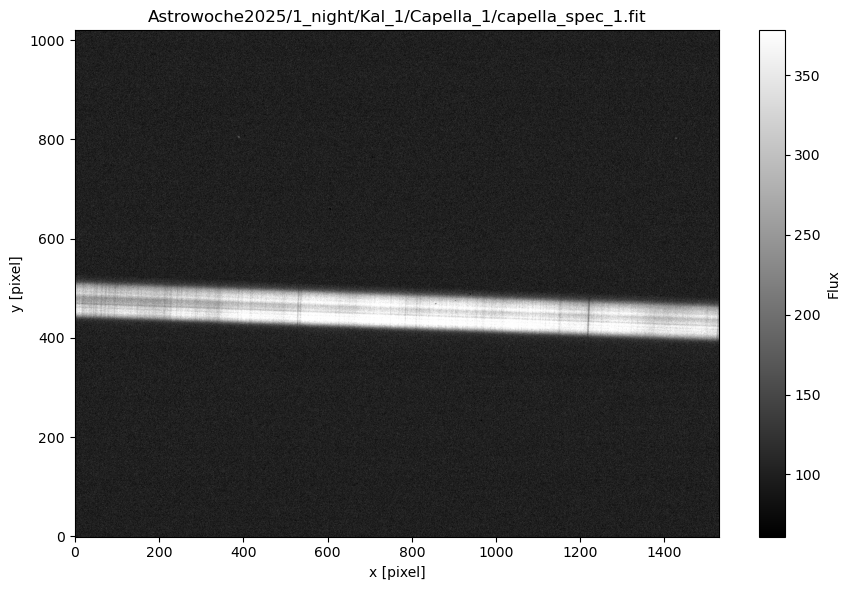

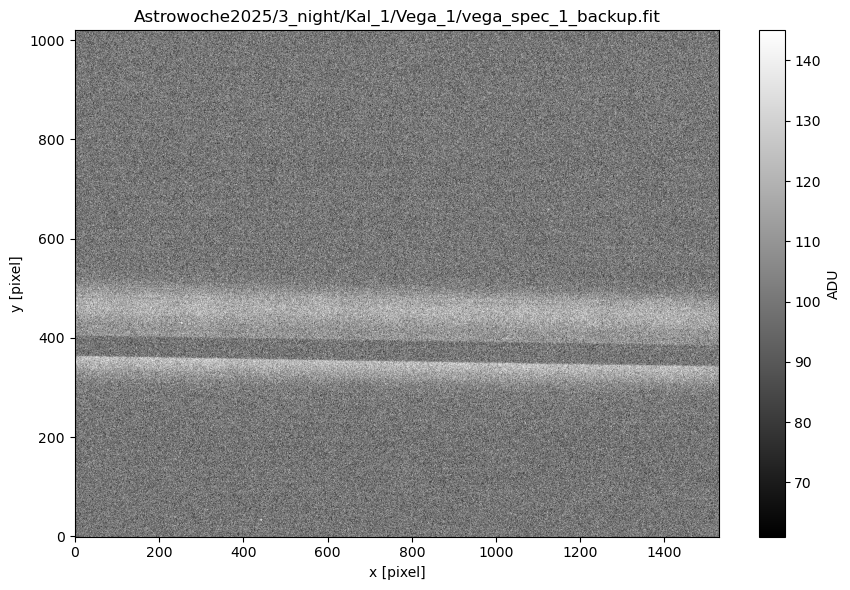

In [107]:
path1 = "Astrowoche2025/1_night/Kal_1/Capella_1/capella_spec_1.fit"
# path1 = "Astrowoche2025/3_night/Kal_1/kal_1_0_35/kal_1_0_35_after.fit"

with fits.open(path1) as hdul:
    hdul.info()                   # zeigt genau das, was du gepostet hast
    data1 = hdul[0].data.astype(np.float32)   # wichtig: in float umwandeln
    header = hdul[0].header

path2 = "Astrowoche2025/3_night/Kal_1/Vega_1/vega_spec_1_backup.fit"
# path2 = "Astrowoche2025/1_night/Kal_1/kal_1_after.fit"
# path2 = "Astrowoche2025/3_night/Kal_1/kal_1_1_25/1_25/kal_1_1_25.fit"
# path2 = "Astrowoche2025/1_night/Kal_2/kal_0_35/kal_0_35_after.FIT"


with fits.open(path2) as hdul:
    hdul.info()                   # zeigt genau das, was du gepostet hast
    data2 = hdul[0].data.astype(np.float32)   # wichtig: in float umwandeln
    header = hdul[0].header
vmin, vmax = np.percentile(data1, [1, 99])

# Image 1
plt.figure(figsize=(9,6))
plt.imshow(data1, origin="lower", cmap="gray", vmin=vmin, vmax=vmax, aspect="auto")
plt.colorbar(label="Flux")
plt.title(path1)
plt.xlabel("x [pixel]")
plt.ylabel("y [pixel]")
plt.tight_layout()
plt.show()

vmin, vmax = np.percentile(data2, [1, 99])
#Image 2
plt.figure(figsize=(9,6))
plt.imshow(data2, origin="lower", cmap="gray", vmin=vmin, vmax=vmax, aspect="auto")
plt.colorbar(label="ADU")
plt.title(path2)
plt.xlabel("x [pixel]")
plt.ylabel("y [pixel]")
plt.tight_layout()
plt.show()

y0: 244
y1: 304


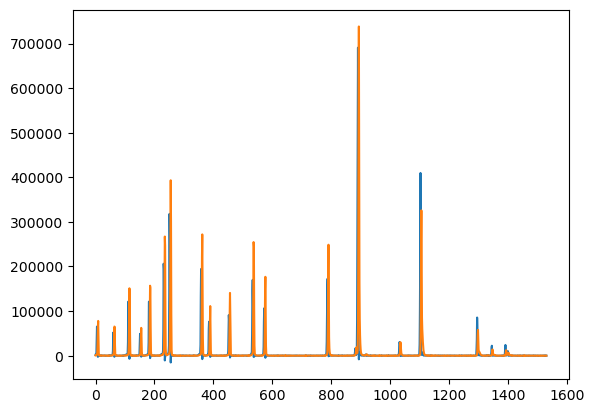

In [10]:
x1, s1, y0, *rest = extract_1d_spectrum(data1, filtering = False, normalize = False)
x2, s2, y1, *rest = extract_1d_spectrum(data2, filtering = False, normalize = False)


print("y0:", y0)
print("y1:", y1)
plt.plot(x1,s1)
plt.plot(x2,s2)
plt.show()

## Estimate Shift

In [113]:
def multiple_files(folder_path, filtering = False, normalize= False, delta = 10):
    
    spec_all  = []


    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        img = fits.getdata(file_path)
        pixel, spec, *rest = extract_1d_spectrum(img, filtering = filtering, normalize= normalize, delta = delta)
        print(file_path)
        spec_all.append(spec)
        print(len(spec))
    
    spectra = np.array(spec_all)
    pixel = np.arange(spectra.shape[1])

    avg_spectra = np.median(spectra, axis = 0)
    return pixel, avg_spectra

def preprocess_1d(spec, smooth=101):
    spec = spec.astype(np.float32)

    # NaNs raus
    spec = np.nan_to_num(spec, nan=np.nanmedian(spec))

    # Kontinuum schätzen und entfernen (flattening)
    cont = median_filter(spec, size=smooth)
    cont = np.clip(cont, 1e-6, None)
    h = spec / cont
    h = h - np.median(h)

    # Normieren
    s = np.std(h)
    if s > 0:
        h /= s

    # Fenstern gegen FFT wrap-around
    w = np.hanning(len(h)).astype(np.float32)
    h *= w

    return h


def combine_spec(path1, path2, folder1 : bool = False, folder2 : bool = False, plot: bool= True, shift = None, scal = None, filtering = False, normalize = False, delta = 10):
    """Finds shift of image 1 in image 2 and combines the two spectras by the correpsonding shift. 

    Args:
        path1 (fits file): data of grating setting 1_25
        path2 (fits file): data of grating setting 0_35
        folder1: if path1 corresponds to a folder
        folder2: if path2 corresponds to a folder
        plot: if True, then plot will be displayed
        shift: if None, phase_cross_correlation will determine shift
        scal: if not none, then the spectrum will be made more continuous
        filtering: if True, extract_1d_spectrum will filter data

    Returns:
        x_comb: combined x axis
        s_comb: combined spectrum
        x1, s1: x and spectrum of grating setting 1_25
        x2, s2: x and spectrum of grating setting 0_35
        shift: determined shift between both images
    """
    # load FITS 


    if (folder1 == 1) & (folder2 == 1):
        x1, s1 = multiple_files(path1, filtering = filtering, normalize= normalize, delta = delta) 
        x2, s2 = multiple_files(path2, filtering = filtering,normalize= normalize, delta = delta) 
    elif (folder1 == 1) & (folder2 != 0):
        x1, s1 = multiple_files(path1, filtering = filtering, normalize= normalize, delta = delta)
        img2 = fits.getdata(path2)

        x2, s2, *rest = extract_1d_spectrum(img2, half_height=10, filtering=filtering, normalize= normalize, delta = delta)
    elif (folder2 ==1): 
        img1 = fits.getdata(path1)
        x1, s1, *rest =  extract_1d_spectrum(img1, half_height=10, filtering=filtering, normalize= normalize, delta = delta)
        x2, s2 = multiple_files(path2, filtering, normalize= normalize, delta = delta)
    else:
        img1 = fits.getdata(path1)
        img2 = fits.getdata(path2)
        x1, s1, *rest =  extract_1d_spectrum(img1, half_height=10, filtering = filtering, normalize= normalize, delta = delta)
        x2, s2, *rest = extract_1d_spectrum(img2, half_height=10, filtering = filtering, normalize= normalize, delta = delta)


    if shift is None:
        shift, error, phasediff = phase_cross_correlation(s1, s2, upsample_factor=50)
        print("shift:", shift)  # bei 1D: ein Array mit einem Wert

    
    if scal is not None: 
        _shift = abs(shift)    
        scal = s1[-_shift]/s2[0] #determine "factor" between the last point of s1 and first point of s2.
        s2 *= scal #make spectrum more continuous
 
    x_comb, s_comb = stitch_spectra(s1, s2, shift= int(shift)) # erster eintrag muss grating 0_35 sein zweiter 1_25



    if plot == True: 
        # mOnlyA = mA & ~mB
        # mOnlyB = mB & ~mA
        # mOverlap = mA & mB
        fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=False)

        # --- 1: Gestitchtes Spektrum ---
        axes[0].plot(x_comb, s_comb, lw=1)
        # axes[0].plot(x_comb[mOnlyA], s_comb[mOnlyA], lw=1, label="A only")
        # axes[0].plot(x_comb[mOnlyB], s_comb[mOnlyB], lw=1, label="B only")
        # axes[0].plot(x_comb[mOverlap], s_comb[mOverlap], lw=1, label="overlap")
        axes[0].set_title("Stitched 1D spectrum (overlap averaged)")
        axes[0].set_ylabel("Flux [ADU]")
        axes[0].grid(True, alpha=0.3)

        # --- 2: kal_2_25 ---
        axes[1].plot(x1, s1, lw=1, color='g', label=path1)
        axes[1].legend()
        axes[1].set_ylabel("Flux [ADU]")
        axes[1].grid(True, alpha=0.3)

        # --- 3: kal_0_35 ---
        axes[2].plot(x2, s2, lw=1, color='r', label=path2)
        axes[2].legend()
        axes[2].set_xlabel("Pixel")
        axes[2].set_ylabel("Flux [ADU]")
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


    return x_comb, s_comb, shift, x1, s1, x2, s2, scal

  
    

# Wavelength calibration

In [13]:
def calibrate_wavelength(x_comb, s_comb, deg = 1, plot: bool = True):
    

    path = "Astrowoche2025/Ne_spec.csv"
    # CSV einlesen
    ref = pd.read_csv(path)

    # In float konvertieren (alles Nicht-Numerische wird NaN)
    ref["Wavelength (angstrom)"] = pd.to_numeric(ref["Wavelength (angstrom)"], errors="coerce")
    ref["Intensity"] = pd.to_numeric(ref["Intensity"], errors="coerce")

    # Jetzt erst filtern
    ref = ref[(ref["Wavelength (angstrom)"] > 5800) & 
              (ref["Wavelength (angstrom)"] < 7300) & (ref["Intensity"] > 50)]

    wavelength = ref["Wavelength (angstrom)"].to_numpy(dtype=np.float64)
    intensity  = ref["Intensity"].to_numpy(dtype=np.float64)

    ref_w = wavelength
    ref_w_diff = np.diff(ref_w)
    ref_I = intensity


    best_error = np.inf

    peaks, props = find_peaks(s_comb,height = 3000)

    # for i in range(len(x_comb) - len(ref_w) +1):
    #     pix_subset = x_comb[i:i+len(ref_w)]

    #     coeffs, cov = np.polyfit(pix_subset, ref_w, deg=deg, cov = True)
    #     error = np.std(np.polyval(coeffs, pix_subset) - ref_w) 

    #     if error < best_error:
    #         best_error = error
    #         best_coeffs = coeffs

    for i in range(len(peaks) - len(ref_w) +1):
        pix_subset = x_comb[peaks][i:i+len(ref_w)]

        coeffs, cov = np.polyfit(pix_subset, ref_w, deg=deg, cov = True)
        error = np.std(np.polyval(coeffs, pix_subset) - ref_w) 

        if error < best_error:
            best_error = error
            best_coeffs = coeffs

    return best_coeffs


    

In [84]:
def fit_from_two_points(x1, x2, l1, l2):
    a1 = (l2 - l1) / (x2 - x1)
    a0 = l1 - a1 * x1
    return np.array([a1, a0])  # np.polyval erwartet [a1, a0] für deg=1

def count_inliers(coeff, x_peaks, lam_ref, tol=1.0):
    lam_pred = np.polyval(coeff, x_peaks)
    # Abstand jedes Predicted zu nächster Referenzlinie
    dist = np.array([np.min(np.abs(lam_ref - lp)) for lp in lam_pred])
    return np.sum(dist < tol), dist

def calibrate_with_anchor(x_comb, s_comb, ref_w, height=3000, lam0=5850.0,
                          N=15, tol=1.0):
    peaks, _ = find_peaks(s_comb, height=height)
    x_peaks = np.sort(x_comb[peaks])

    # Anker: linksester Peak ~ 5800Å
    x0 = x_peaks[0]
    j0 = int(np.argmin(np.abs(ref_w - lam0)))
    l0 = ref_w[j0]

    # Kandidaten: nächste Peaks
    x_obs = x_peaks[:min(len(x_peaks), N)]

    # Kandidaten-Referenz: Bereich rechts vom Anker
    lam_ref_win = ref_w[(ref_w >= l0 - 50) & (ref_w <= l0 + 800)]

    best = None  # (ninliers, coeff)
    # Wir fixen den ersten Punkt (x0->l0) und wählen einen zweiten Punkt
    for xi in x_obs[1:]:
        # zweite Referenzlinie durchprobieren (nicht zu nah an l0)
        for l2 in lam_ref_win:
            if abs(l2 - l0) < 20:
                continue
            if abs(xi - x0) < 10:
                continue

            coeff = fit_from_two_points(x0, xi, l0, l2)
            ninl, _ = count_inliers(coeff, x_peaks, ref_w, tol=tol)

            if best is None or ninl > best[0]:
                best = (ninl, coeff)

    return best  # ninliers, coeff


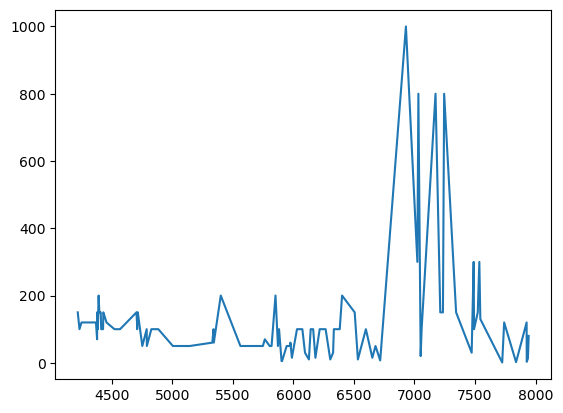

In [15]:
path = "Astrowoche2025/Ne_spec.csv"
# CSV einlesen
ref = pd.read_csv(path)

# In float konvertieren (alles Nicht-Numerische wird NaN)
ref["Wavelength (angstrom)"] = pd.to_numeric(ref["Wavelength (angstrom)"], errors="coerce")
ref["Intensity"] = pd.to_numeric(ref["Intensity"], errors="coerce")

# Zeilen mit kaputten Werten wegwerfen
ref = ref.dropna(subset=["Wavelength (angstrom)", "Intensity"])

# Jetzt erst filtern
ref = ref[(ref["Wavelength (angstrom)"] > 4000) & 
            (ref["Wavelength (angstrom)"] < 8000)]

wavelength = ref["Wavelength (angstrom)"].to_numpy(dtype=np.float64)
intensity  = ref["Intensity"].to_numpy(dtype=np.float64)

ref_w = wavelength
ref_w_diff = np.diff(ref_w)
ref_I = intensity

plt.plot(ref_w, ref_I)

# calibrate Vega

In [96]:
from astropy.io import fits

path = "Astrowoche2025/alpha_lyr_mod_004.fits"

with fits.open(path) as hdul:
    header = hdul["SCI"].header
    data   = hdul["SCI"].data
    
    print(data.names)   # Spaltennamen

    # Einheiten pro Spalte
    for i, name in enumerate(data.names, start=1):
        unit = header.get(f"TUNIT{i}")
        print(name, "->", unit)


['WAVELENGTH', 'FLUX', 'CONTINUUM']
WAVELENGTH -> ANGSTROMS
FLUX -> FLAM
CONTINUUM -> FLAM


Filename: Astrowoche2025/alpha_lyr_mod_004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   ()      
  1  SCI           1 BinTableHDU     23   8094R x 3C   [1D, 1E, 1E]   
['WAVELENGTH', 'FLUX', 'CONTINUUM']


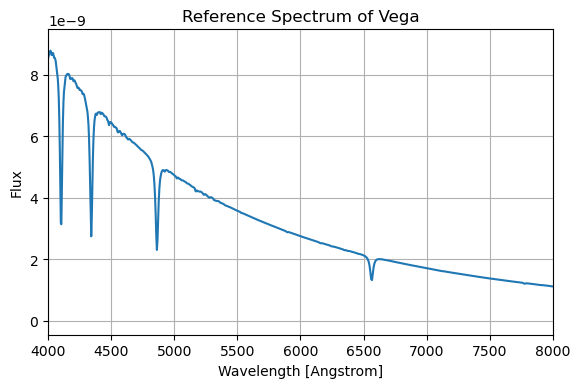

[9.00388727e+02 9.01291391e+02 9.02194936e+02 ... 2.98765844e+06
 2.99065357e+06 2.99365170e+06]


In [115]:
from astropy.io import fits

path_vega = "Astrowoche2025/alpha_lyr_mod_004.fits"

fits.info(path_vega)


with fits.open(path_vega) as hdul:
    tab = hdul["SCI"].data          # oder hdul[1].data
    print(tab.names) 

lam_vega  = tab["WAVELENGTH"]   # Beispielname
flux_vega = tab["FLUX"]


cm = 1/2.54
plt.figure(figsize=(15*cm,10*cm))
plt.plot(lam_vega, flux_vega)
plt.xlim(4000, 8000)
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Flux")
plt.tight_layout()
plt.grid()
plt.title("Reference Spectrum of Vega")
plt.show()

print(lam_vega)


2660


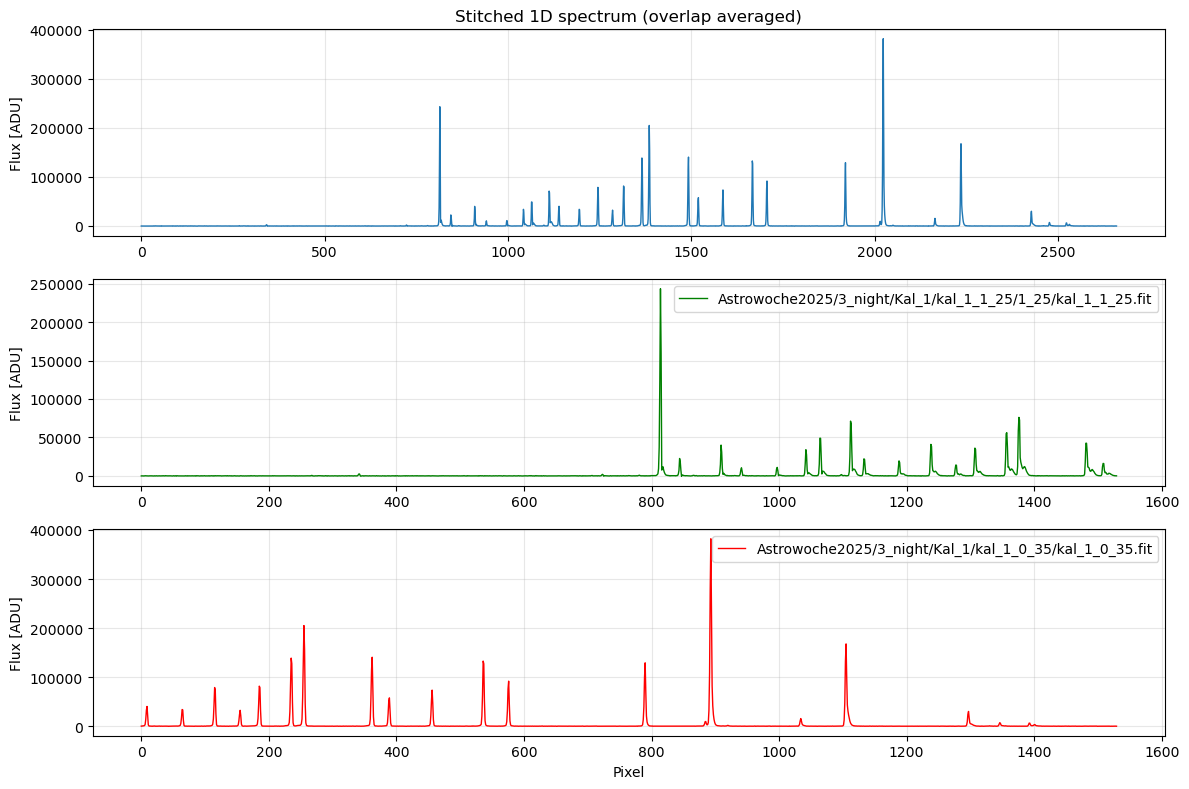

inliers: 11 coeff: [2.06172961e-01 5.63662481e+03]


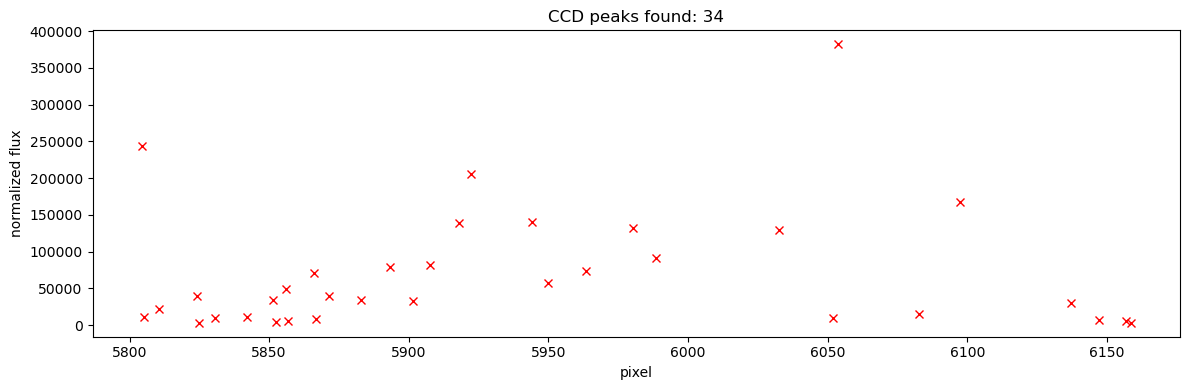

[5804.4496     5805.27429185 5810.63478884 5824.03603133 5824.86072318
 5830.63356609 5842.17925193 5851.45703519 5852.4879     5855.99284034
 5856.81753219 5865.88914249 5866.9200073  5871.45581245 5882.79532532
 5893.31014635 5901.55706481 5907.74225365 5918.05090172 5922.17436094
 5944.23486781 5949.80153777 5963.61512618 5980.10896309 5988.35588155
 6032.47689528 6052.06332661 6053.7127103  6082.78309785 6097.42137811
 6137.0065867  6147.1090618  6156.79919099 6158.44857468]


In [ ]:

path1 = "Astrowoche2025/3_night/Kal_1/kal_1_1_25/1_25/kal_1_1_25.fit"
path2 = "Astrowoche2025/3_night/Kal_1/kal_1_0_35/kal_1_0_35.fit"
shift_3night_1 = 400
x_comb, s_comb, shift, x1, s1, x2, s2, scal_night3_1 = combine_spec(path1, path2, folder1=False, folder2 = False , plot = True, shift = shift_3night_1)




ninl, coeff_night3_1 = calibrate_with_anchor(x_comb, s_comb, ref_w, tol=1.5)
print("inliers:", ninl, "coeff:", coeff_night3_1)

lam_axis = np.polyval(coeff_night3_1, x_comb)
peaks, props = find_peaks(s_comb,height = 3000)
plt.figure(figsize=(12,4))
plt.plot(lam_axis[peaks] ,s_comb[peaks],  "rx", ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("pixel")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()

print(lam_axis[peaks])

### Vega

Astrowoche2025/3_night/Kal_1/Vega_1\vega_spec_1.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_1\vega_spec_1_backup.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_1\vega_spec_1_backup_2.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_2\vega_spec_2.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_2\vega_spec_2_backup.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_2\vega_spec_2_backup_2.FIT
1530
2660


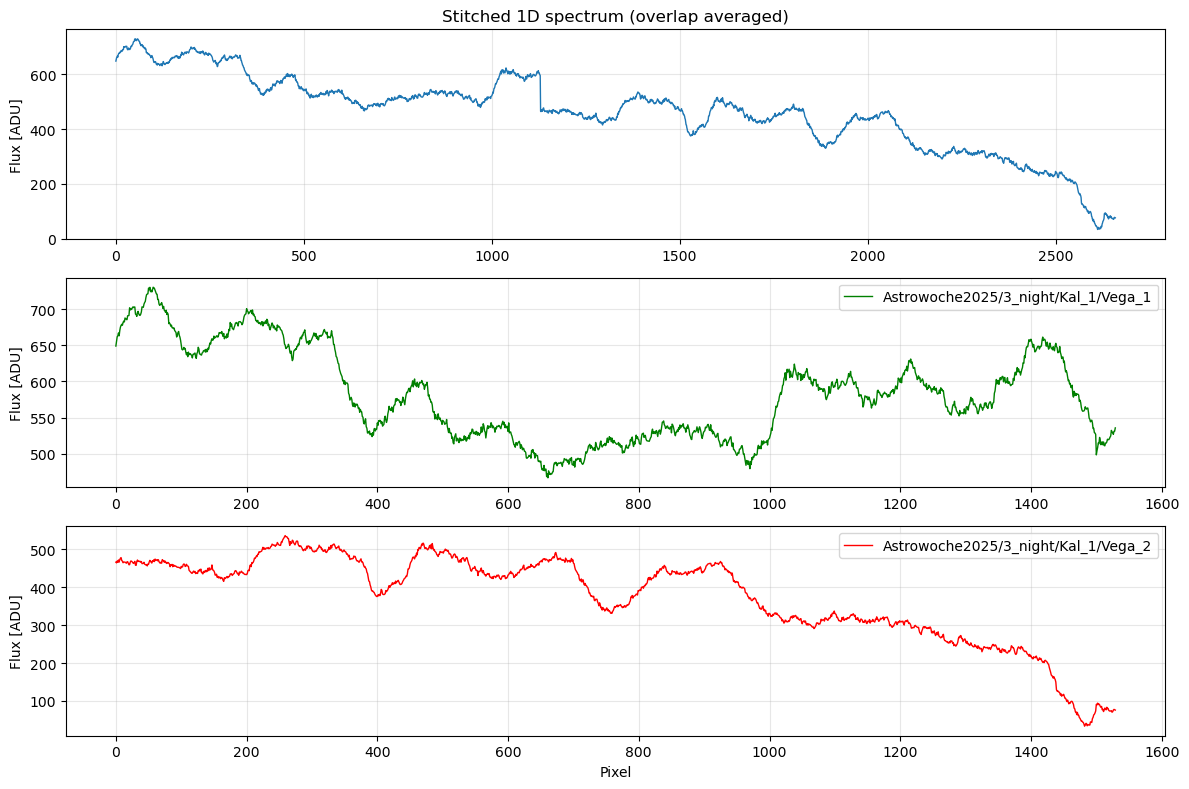

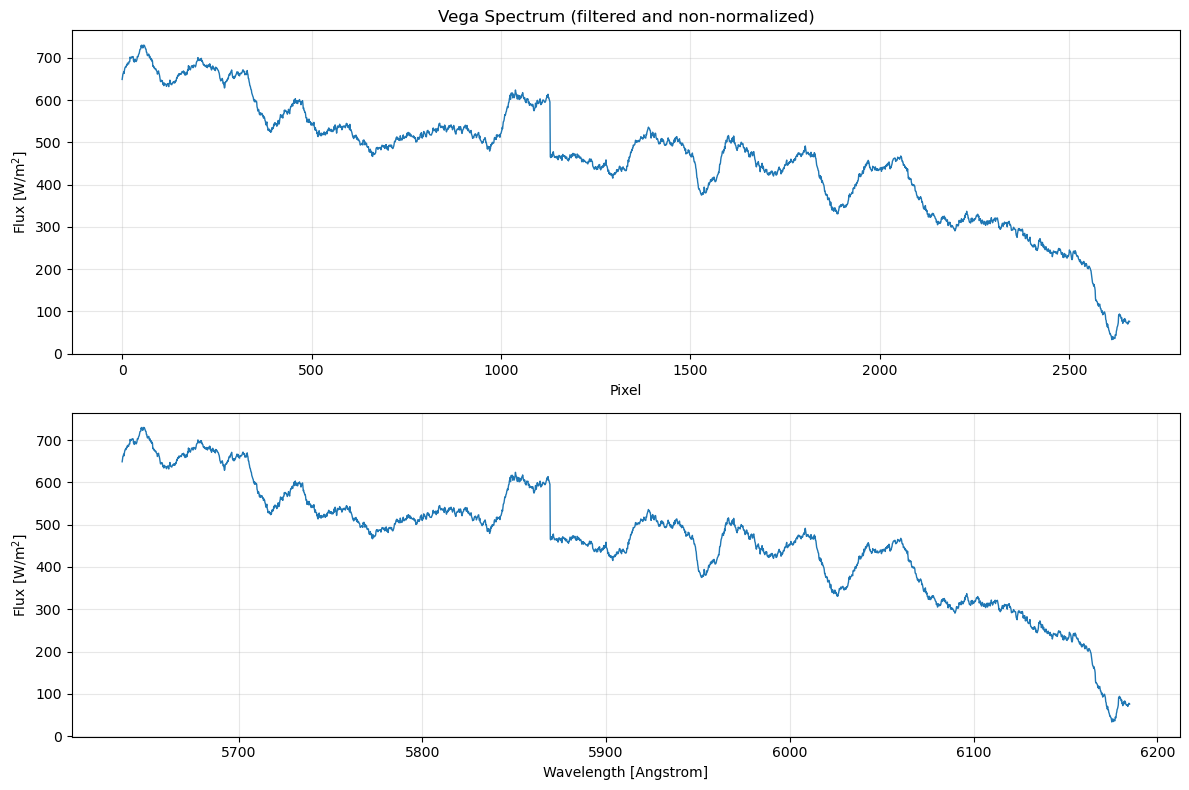

In [ ]:
path1 = "Astrowoche2025/3_night/Kal_1/Vega_1"
path2 = "Astrowoche2025/3_night/Kal_1/Vega_2"


x_comb_vega, s_comb_vega, *rest = combine_spec(path1, path2,folder1= True,  folder2 =True,  plot = True, shift = shift_3night_1, scal = scal_night3_1, filtering = True, normalize = False, delta = 30)
lam_axis_vega = np.polyval(coeff_night3_1, x_comb_vega)
plot_spectrum(x_comb_vega, lam_axis_vega, s_comb_vega, "Vega Spectrum (filtered and non-normalized)")

2660


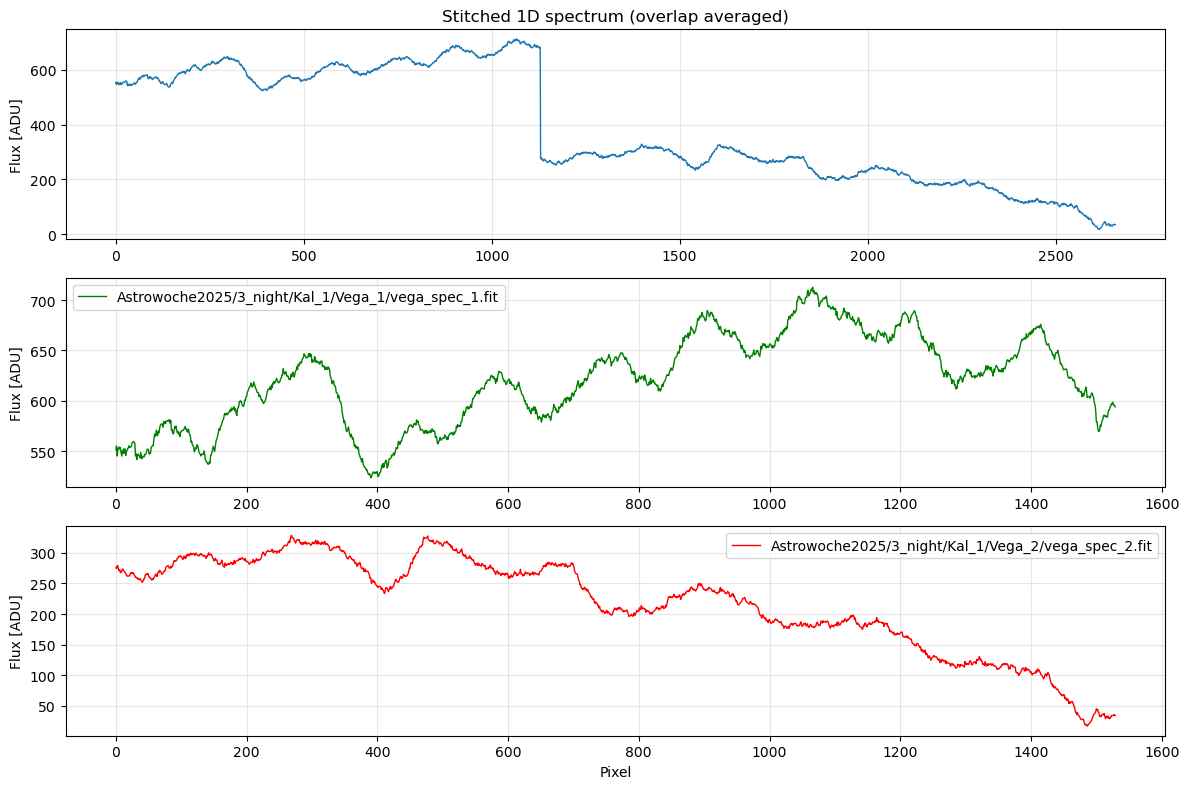

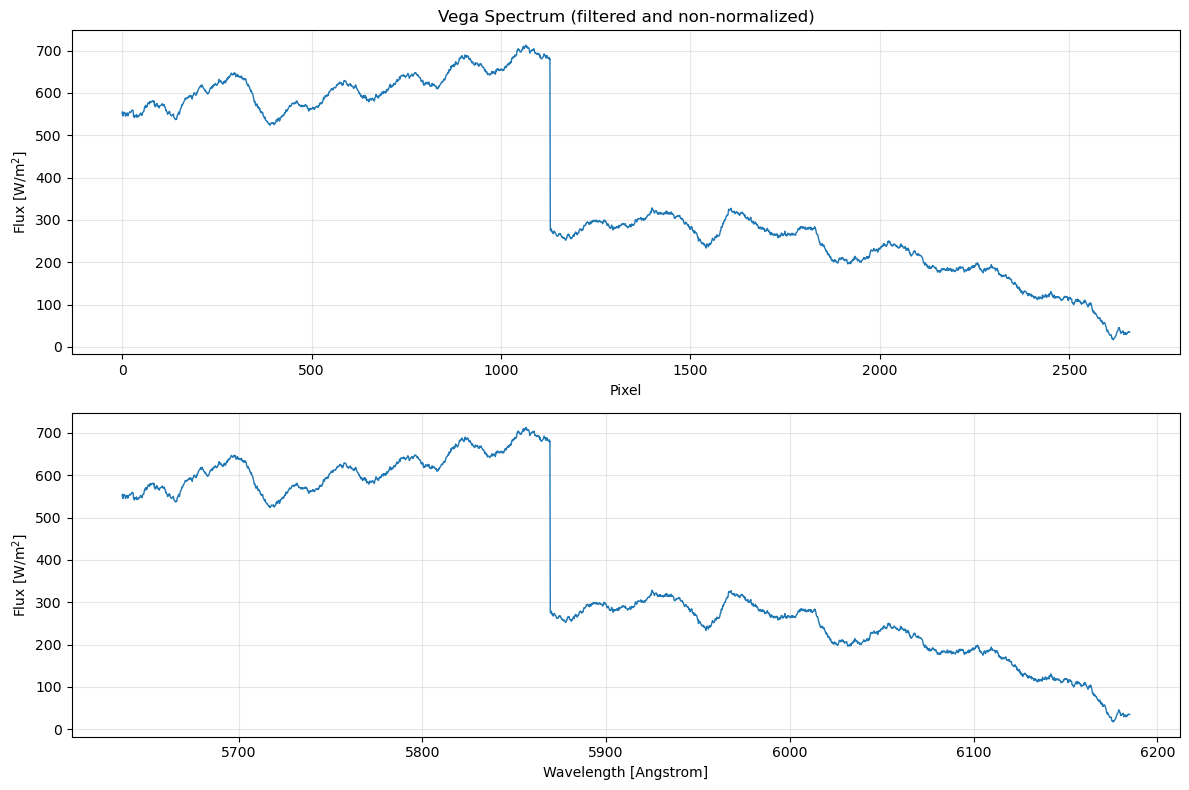

In [ ]:
path1 = "Astrowoche2025/3_night/Kal_1/Vega_1/vega_spec_1.fit"
path2 = "Astrowoche2025/3_night/Kal_1/Vega_2/vega_spec_2.fit"


x_comb_vega, s_comb_vega, *rest = combine_spec(path1, path2,folder1= False,  folder2 =False,  plot = True, shift = shift_3night_1, scal = scal_night3_1, filtering = True, normalize = False, delta = 30)
lam_axis_vega = np.polyval(coeff_night3_1, x_comb_vega)
plot_spectrum(x_comb_vega, lam_axis_vega, s_comb_vega, "Vega Spectrum (filtered and non-normalized)")

# Evaluation Stars

## 1. Night, 1. Calibration

### Wavelength calibration

2360


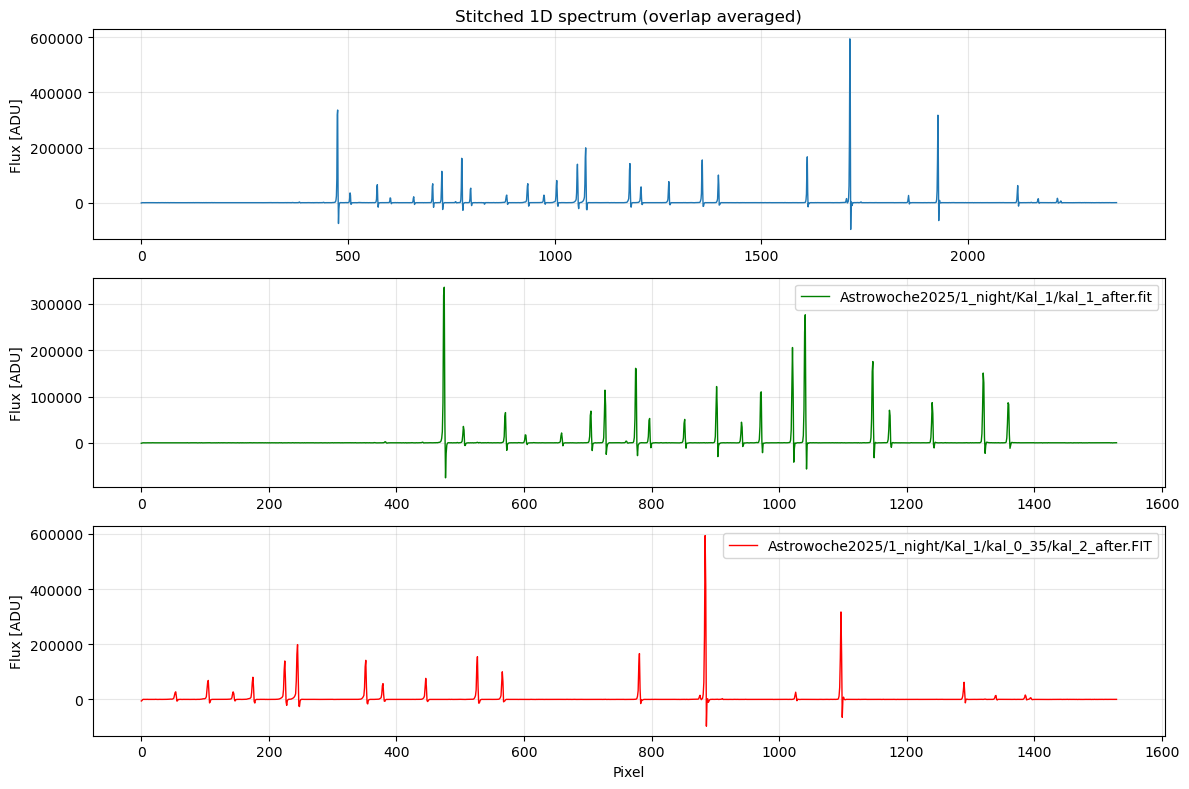

Scal: None
inliers: 15 coeff: [9.66965079e-01 5.39317949e+03]


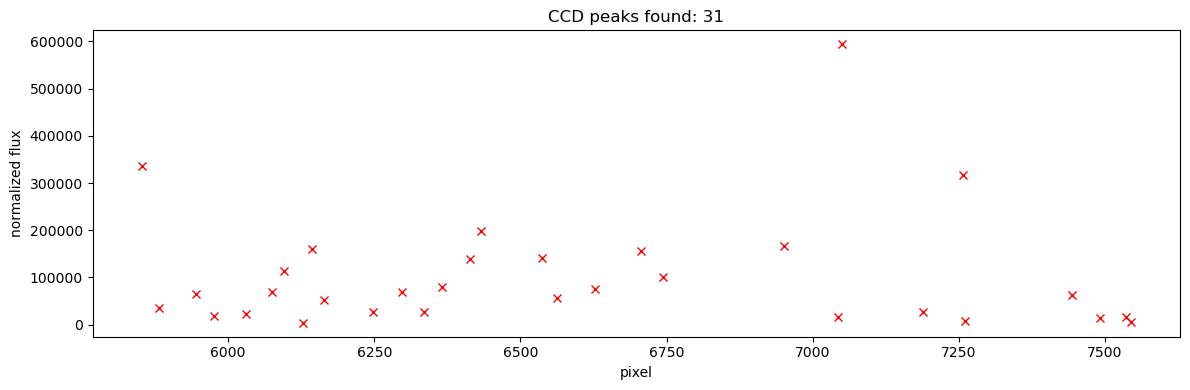

[5852.4879     5881.49685238 5945.31654762 5975.29246508 6030.4094746
 6074.88986825 6096.1631     6128.07294762 6142.57742381 6163.85065556
 6247.97661746 6297.29183651 6335.0034746  6364.97939206 6413.32764603
 6432.66694762 6536.13221111 6562.24026825 6627.02692857 6705.3511
 6743.0627381  6950.96023016 7042.8219127  7050.55763333 7187.8666746
 7256.52119524 7260.38905556 7443.14545556 7491.49370952 7535.97410317
 7543.70982381]


In [108]:

path1 = "Astrowoche2025/1_night/Kal_1/kal_1_after.fit"
path2 = "Astrowoche2025/1_night/Kal_1/kal_0_35/kal_2_after.FIT"

shift_1night_1 = 700
x_comb, s_comb, shift, x1, s1, x2, s2, scal = combine_spec(path1, path2, plot = True, shift = shift_1night_1)

print("Scal:", scal)

ninl, coeff = calibrate_with_anchor(x_comb, s_comb, ref_w, tol=1.5)
print("inliers:", ninl, "coeff:", coeff)

lam_axis = np.polyval(coeff, x_comb)
peaks, props = find_peaks(s_comb,height = 3000)
plt.figure(figsize=(12,4))
plt.plot(lam_axis[peaks] ,s_comb[peaks],  "rx", ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("pixel")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()

print(lam_axis[peaks])


In [ ]:


peaks, props = find_peaks(s_comb,height = 3000)


plt.figure(figsize=(12,4))
plt.plot(x_comb, s_comb, lw=1)
plt.plot(x1, s1, "rx", ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("pixel")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12,4))
plt.plot(x_comb, s_comb, lw=1)
plt.plot(x_comb[peaks], s_comb[peaks], "rx", ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("pixel")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()


coeffs = calibrate_wavelength(x_comb, s_comb)
print(shift)


inliers: 12 coeff: [9.67306308e-01 5.39398471e+03]


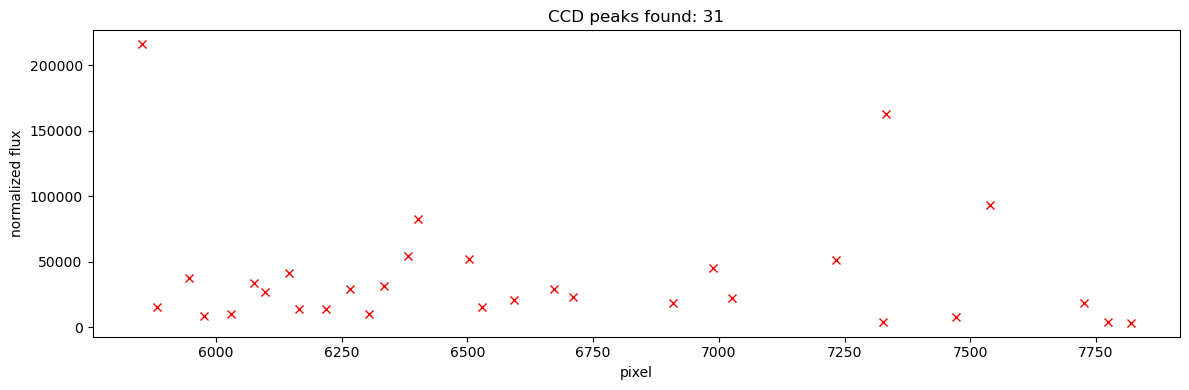

[5852.4879     5882.47439556 5945.34930561 5976.30310748 6030.47226075
 6074.96835093 6097.21639603 6144.61440514 6164.92783762 6218.12968458
 6266.495      6304.21994603 6334.20644159 6381.6044507  6400.95057687
 6503.48504556 6528.63500958 6593.44453224 6671.79634322 6709.52128925
 6909.75369509 6988.10550607 7025.8304521  7233.80130841 7325.69540771
 7333.43385818 7470.79135397 7539.47010187 7726.16021939 7774.52553481
 7819.021625  ]


In [184]:
ninl, coeff = calibrate_with_anchor(x_comb, s_comb, ref_w, tol=1.5)
print("inliers:", ninl, "coeff:", coeff)

lam_axis = np.polyval(coeff, x_comb)

# print(ref_w)
# print(len(ref_w))
# print(len(peaks))
plt.figure(figsize=(12,4))
# plt.plot(x_comb, s_comb, lw=1)
plt.plot(lam_axis[peaks] ,s_comb[peaks],  "rx", ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("pixel")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()

print(lam_axis[peaks])


### Rigel

Astrowoche2025/1_night/Kal_1/Rigel_2\rigel_spec_2.FIT
1530
Astrowoche2025/1_night/Kal_1/Rigel_2\rigel_spec_2_backup.FIT
1530
Astrowoche2025/1_night/Kal_1/Rigel_2\rigel_spec_2_backup_2.FIT
1530
2360


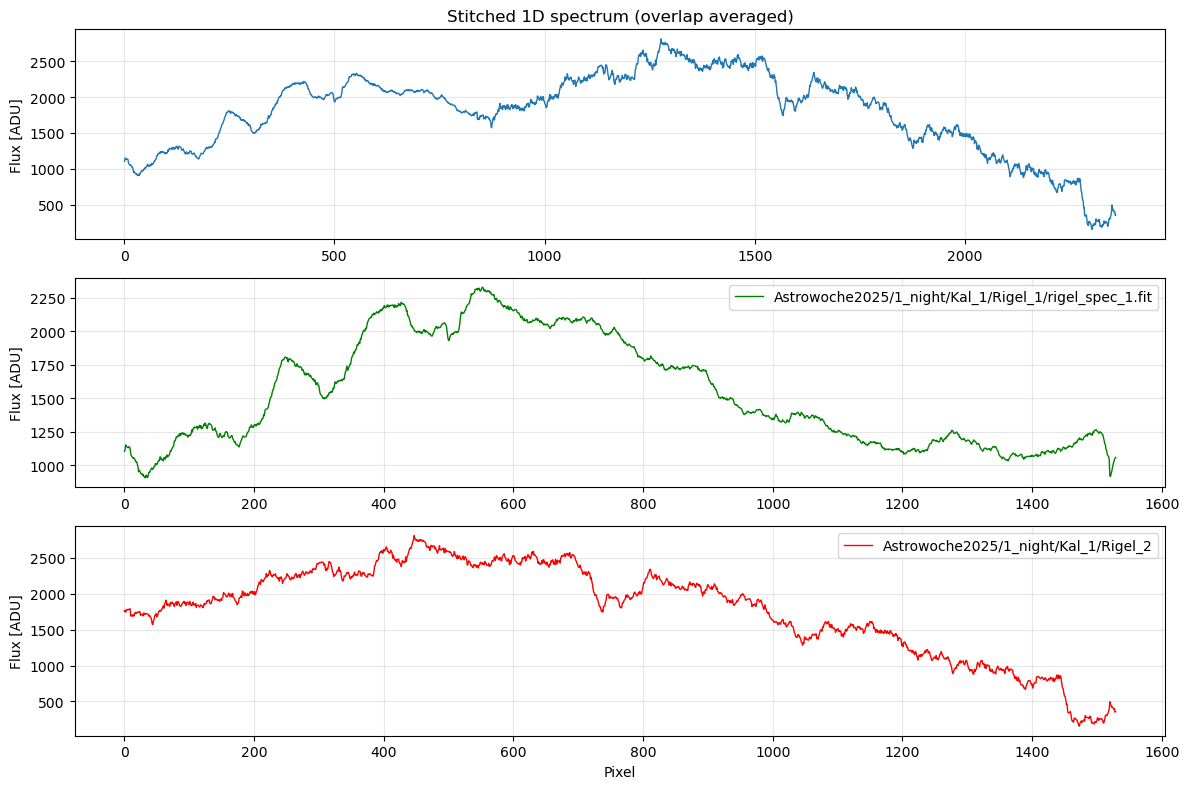

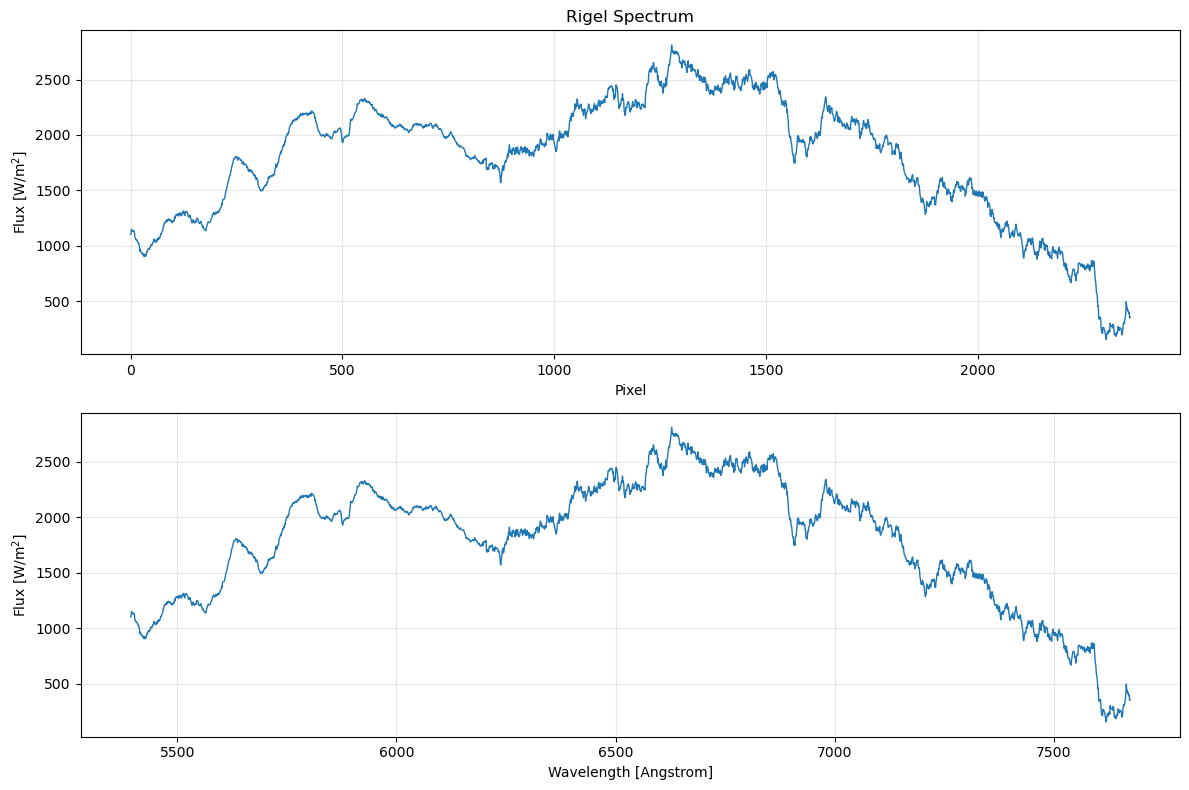

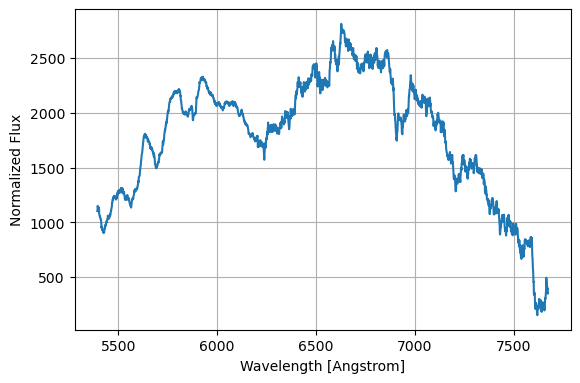

In [109]:
path1 = "Astrowoche2025/1_night/Kal_1/Rigel_1/rigel_spec_1.fit"
path2 = "Astrowoche2025/1_night/Kal_1/Rigel_2"


x_comb_rigel, s_comb_rigel, *rest = combine_spec(path1, path2, folder2 =True, plot = True, scal = 1, shift = shift_1night_1, filtering = True)
lam_axis_rigel = np.polyval(coeff, x_comb_rigel)
plot_spectrum(x_comb_rigel, lam_axis_rigel, s_comb_rigel, "Rigel Spectrum")

### Capella

Astrowoche2025/1_night/Kal_1/Capella_2\capella_spec_2.FIT
1530
Astrowoche2025/1_night/Kal_1/Capella_2\capella_spec_2_backup.FIT
1530
Astrowoche2025/1_night/Kal_1/Capella_2\capella_spec_2_backup_2.FIT
1530
2360


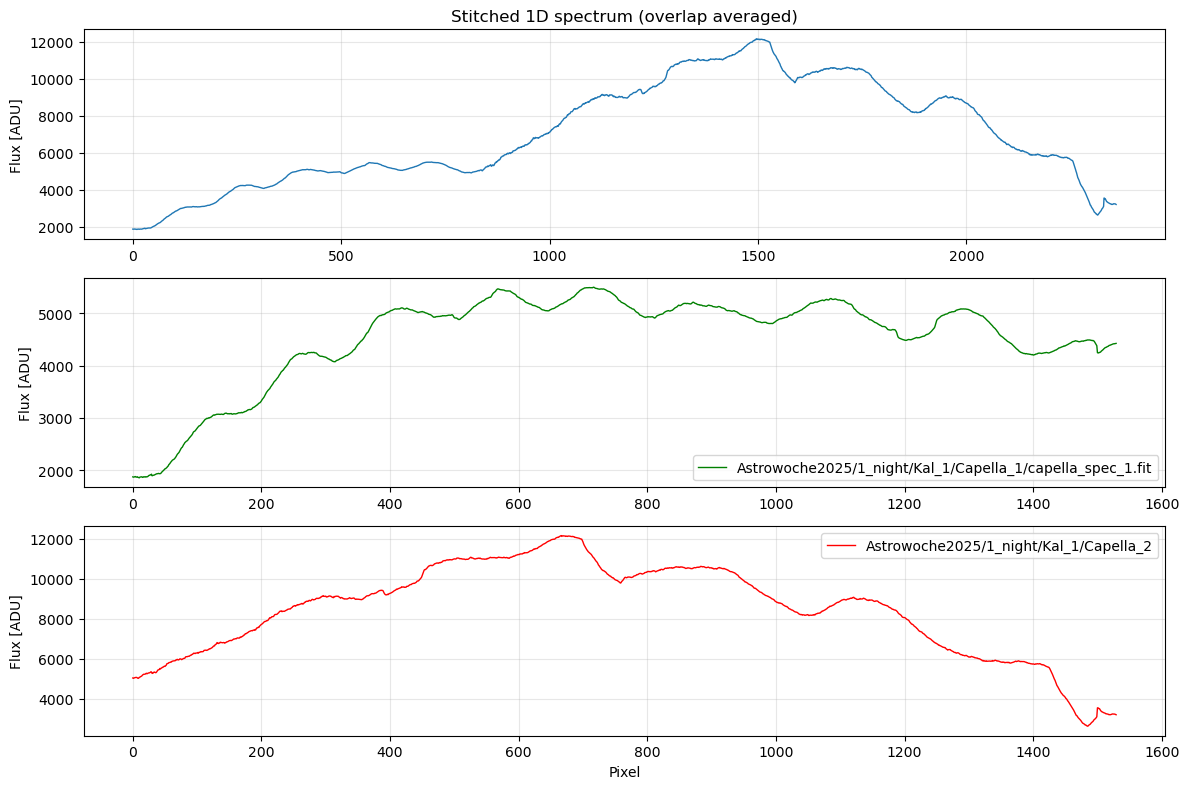

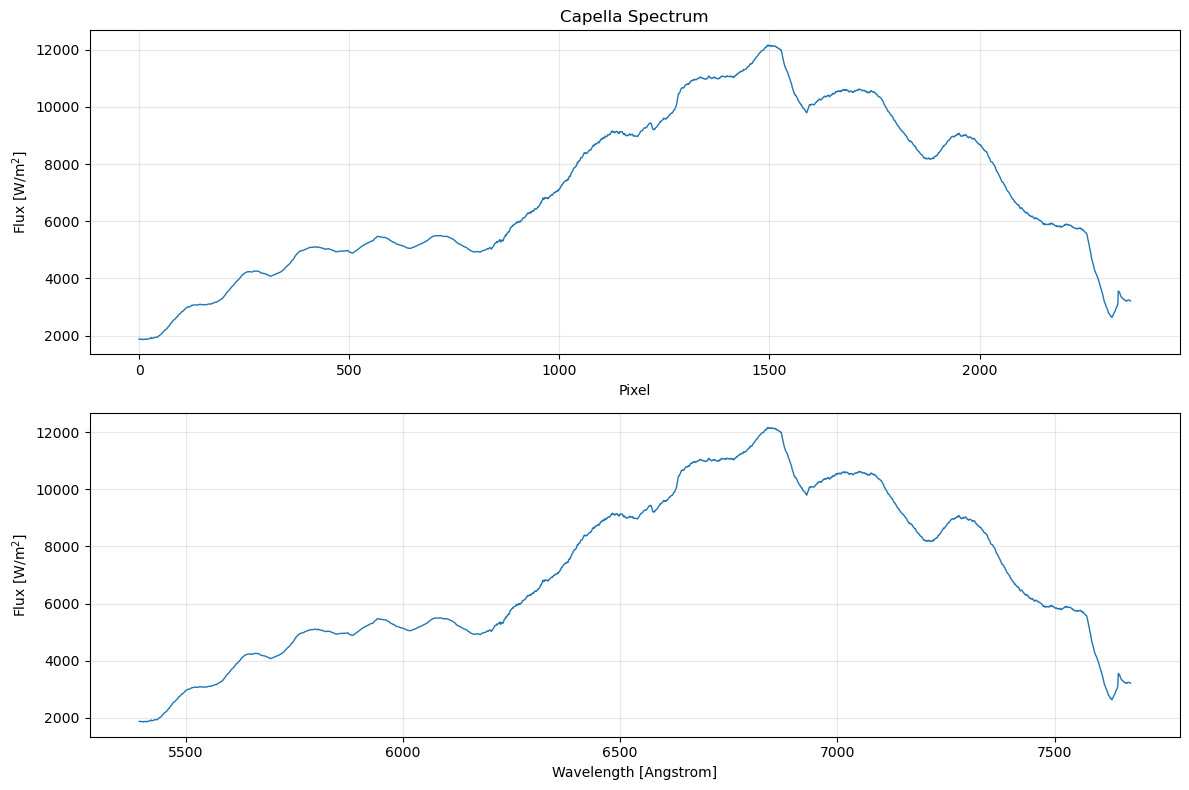

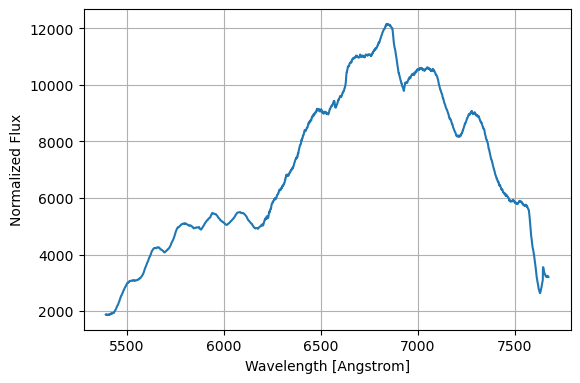

In [117]:
path1 = "Astrowoche2025/1_night/Kal_1/Capella_1/capella_spec_1.fit"
path2 = "Astrowoche2025/1_night/Kal_1/Capella_2"

x_comb_capella, s_comb_capella, *rest = combine_spec(path1, path2, folder2=True, plot = True, scal = 1, filtering = True, shift = shift_1night_1, delta = 30)
lam_axis_capella = np.polyval(coeff, x_comb_capella)
plot_spectrum(x_comb_capella, lam_axis_capella, s_comb_capella, "Capella Spectrum")

### Mirfak

Astrowoche2025/1_night/Kal_1/mirfak_2\mirfak_spec_2.FIT
1530
Astrowoche2025/1_night/Kal_1/mirfak_2\mirfak_spec_2_backup.FIT
1530
Astrowoche2025/1_night/Kal_1/mirfak_2\mirfak_spec_2_backup_2.FIT
1530
2360


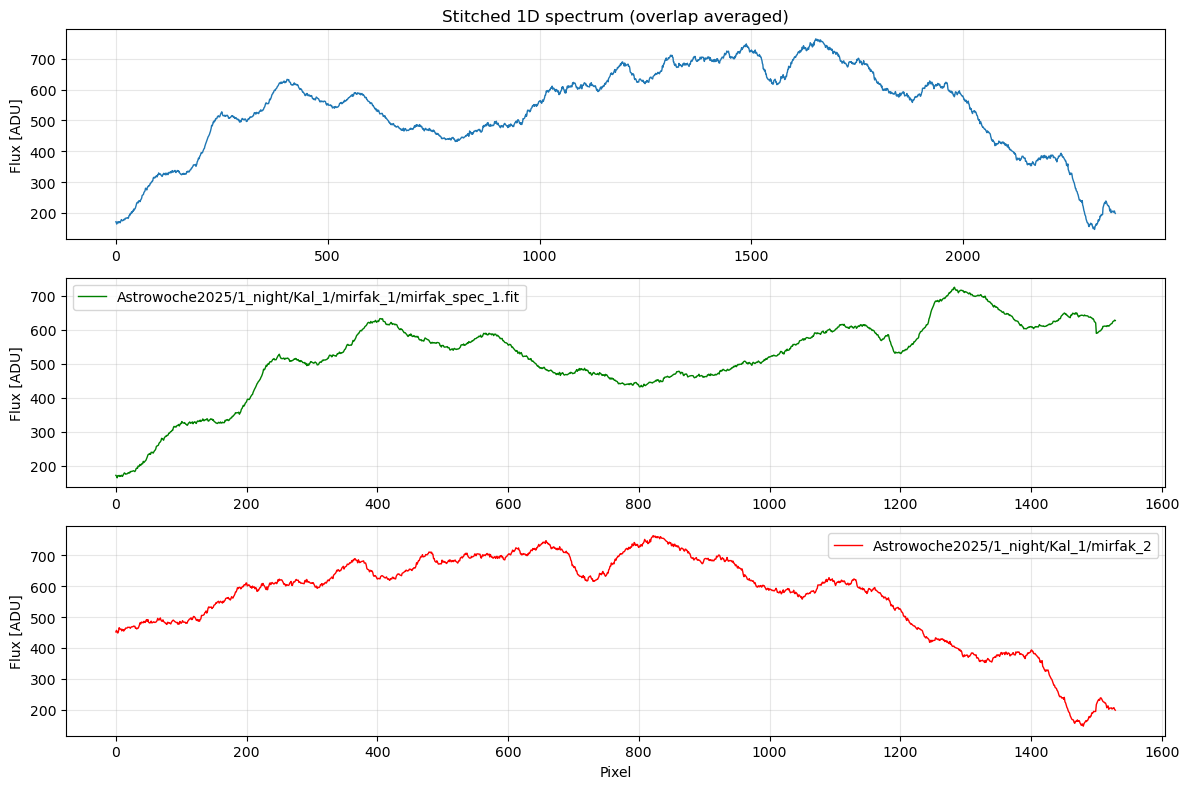

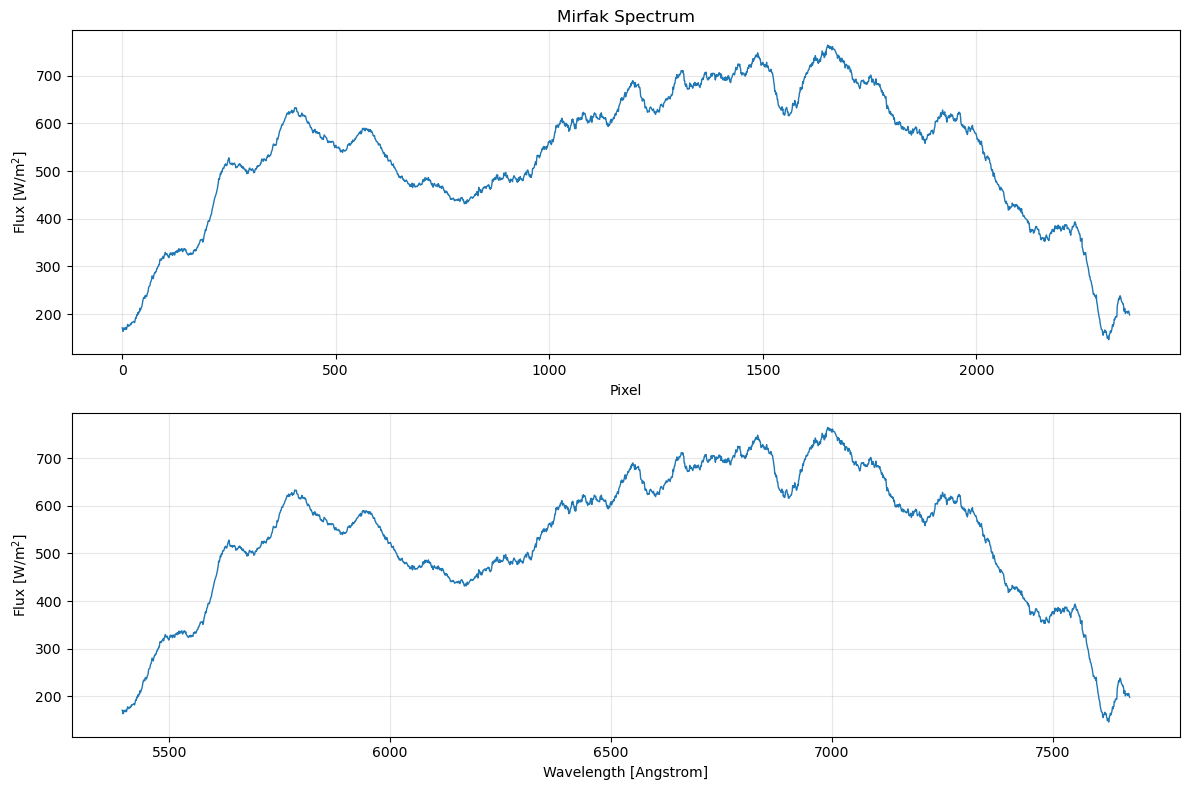

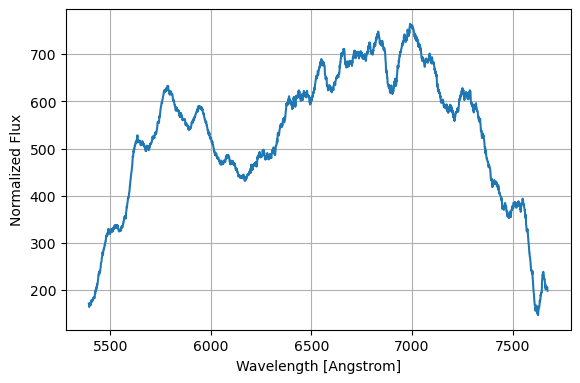

In [118]:
path1 = "Astrowoche2025/1_night/Kal_1/mirfak_1/mirfak_spec_1.fit"
path2 = "Astrowoche2025/1_night/Kal_1/mirfak_2"

x_comb_mirfak, s_comb_mirfak, *rest = combine_spec(path1, path2, folder2=True, plot = True, scal = 1,filtering = True ,shift = shift_1night_1, delta = 30)
lam_axis_mirfak = np.polyval(coeff, x_comb_mirfak)
plot_spectrum(x_comb_mirfak, lam_axis_mirfak, s_comb_mirfak, "Mirfak Spectrum")

### Pollux

Astrowoche2025/1_night/Kal_1/pollux_2\pollux_spec_2.FIT
1530
2360


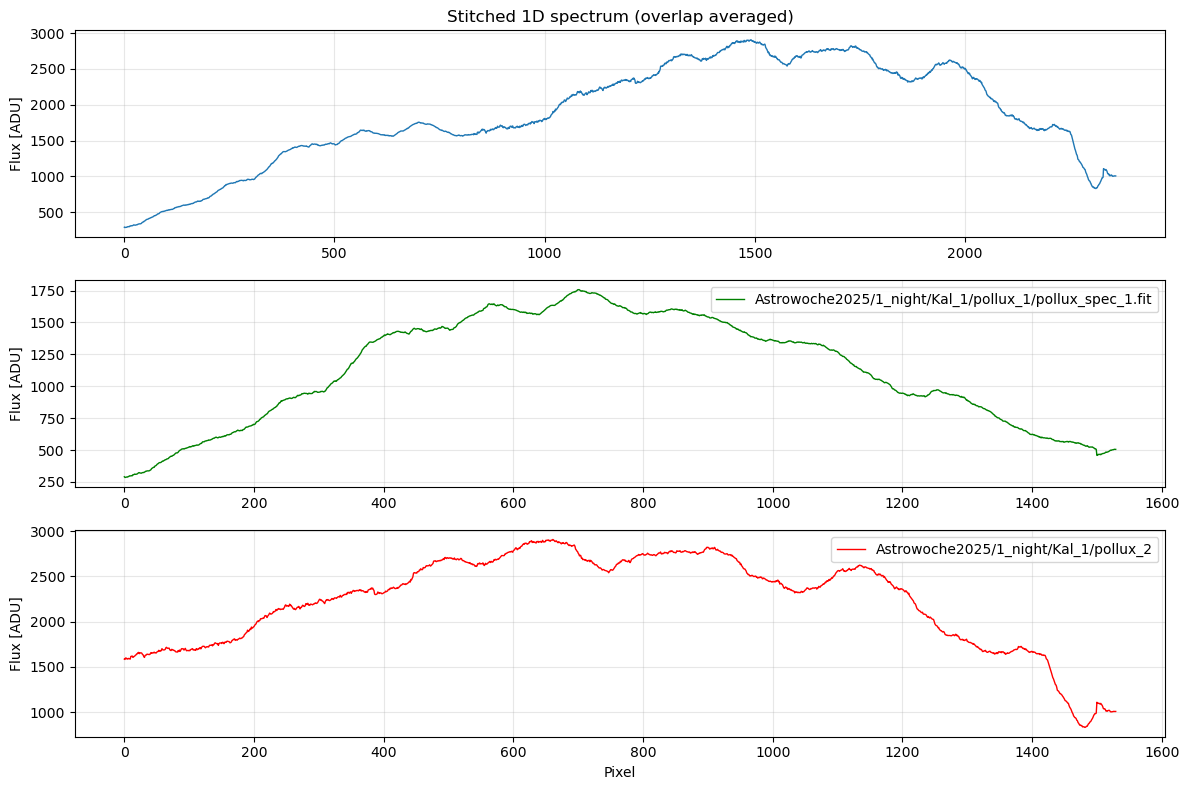

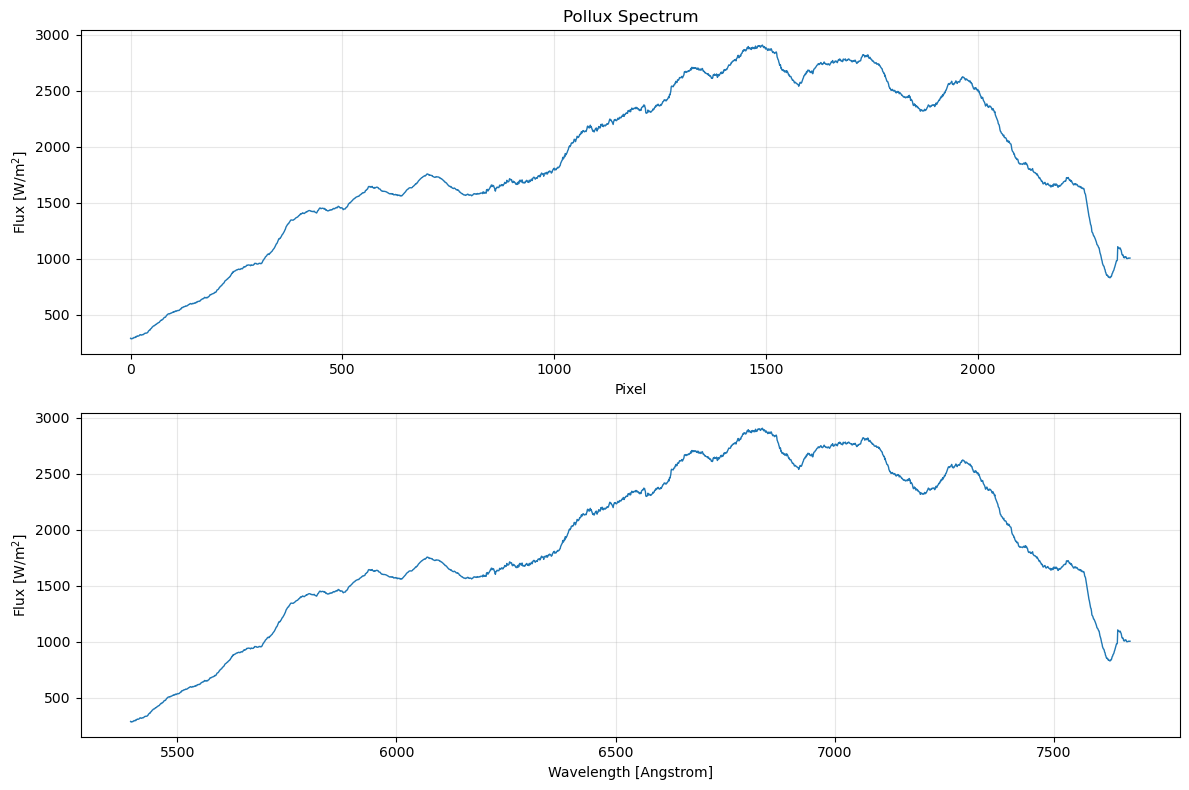

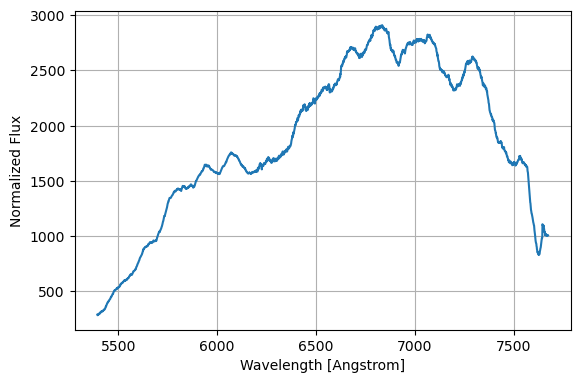

In [119]:
path1 = "Astrowoche2025/1_night/Kal_1/pollux_1/pollux_spec_1.fit"
path2 = "Astrowoche2025/1_night/Kal_1/pollux_2"

x_comb_pollux, s_comb_pollux, *rest = combine_spec(path1, path2, folder2=True, plot = True,scal = 1, shift = shift_1night_1, filtering = True, delta = 30)
lam_axis_pollux = np.polyval(coeff, x_comb_pollux)
plot_spectrum(x_comb_pollux, lam_axis_pollux, s_comb_pollux, "Pollux Spectrum")

## 1. Night second round

### calibration

Astrowoche2025/1_night/Kal_2/kal_1_25\kal_1_25.FIT
1530
Astrowoche2025/1_night/Kal_2/kal_1_25\kal_1_25_after.FIT
1530
Astrowoche2025/1_night/Kal_2/kal_0_35\kal_0_35.FIT
1530
Astrowoche2025/1_night/Kal_2/kal_0_35\kal_0_35_after.FIT
1530
1960


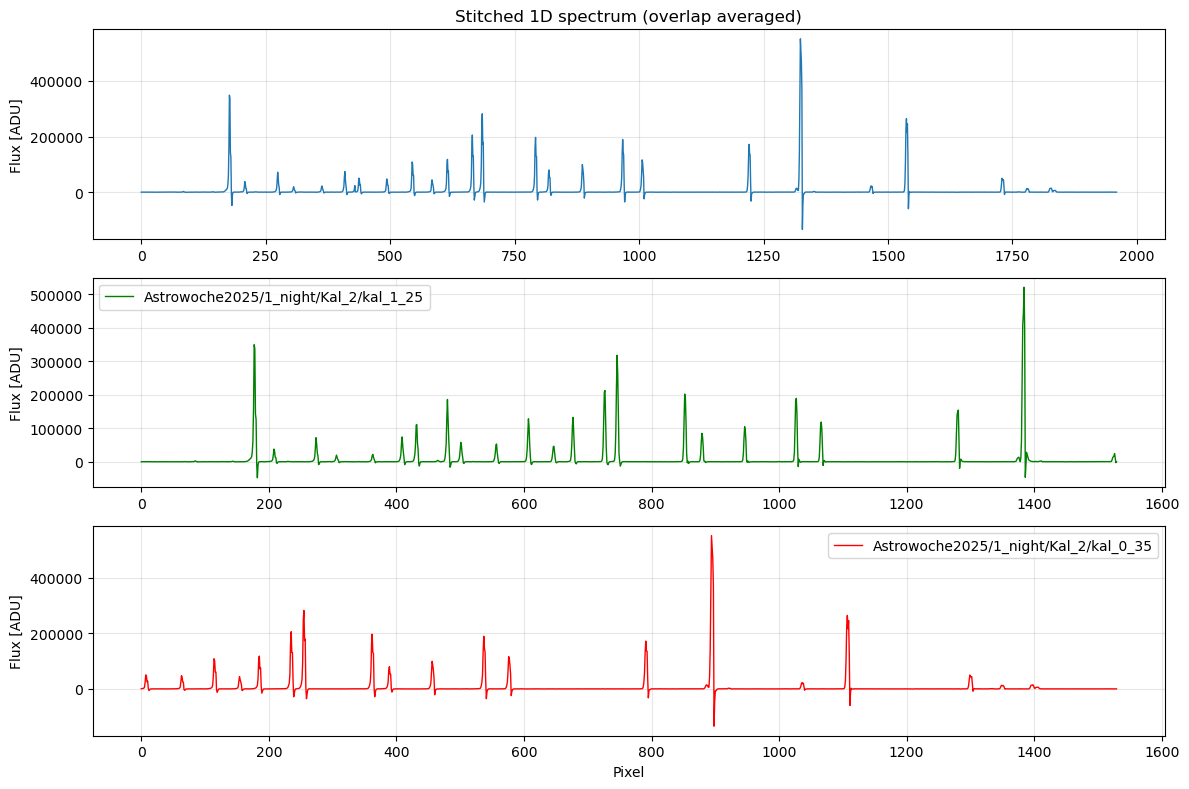

inliers: 12 coeff: [9.66965079e-01 5.39317949e+03]


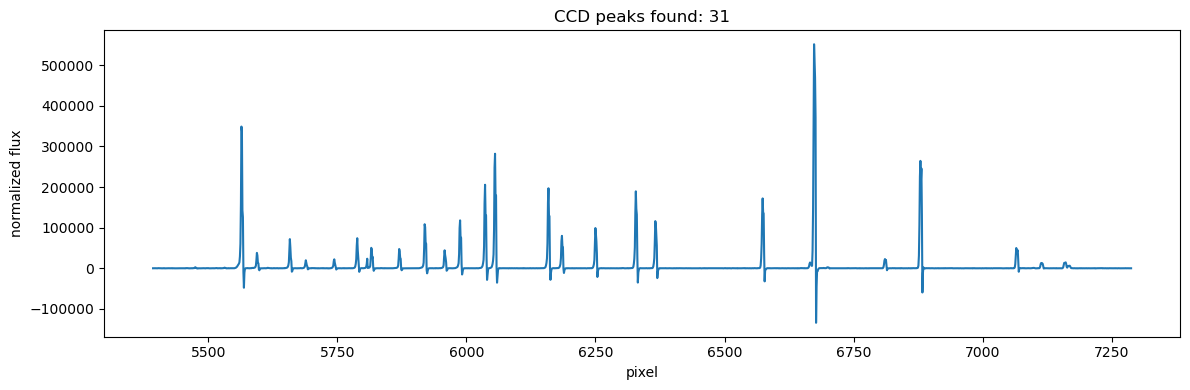

In [127]:

path1 = "Astrowoche2025/1_night/Kal_2/kal_1_25"
path2 = "Astrowoche2025/1_night/Kal_2/kal_0_35"

shift_1night_2 = 1100
x_comb, s_comb, *rest = combine_spec(path1, path2, folder1 = True, folder2=True, plot = True, shift = shift_1night_2)


# peaks, props = find_peaks(s_comb,height = 1000)


# plt.figure(figsize=(12,4))
# plt.plot(x_comb, s_comb, lw=1)
# plt.plot(x_comb[peaks], s_comb[peaks], "rx", ms=6)
# plt.title(f"CCD peaks found: {len(peaks)}")
# plt.xlabel("pixel")
# plt.ylabel("normalized flux")
# plt.tight_layout()
# plt.show()

# n_iff, coeff_night1_2 = calibrate_with_anchor(x_comb, s_comb, ref_w, tol=1.5)

ninl, coeff_night1_2 = calibrate_with_anchor(x_comb, s_comb, ref_w, tol=1.5)
print("inliers:", ninl, "coeff:", coeff)

lam_axis = np.polyval(coeff, x_comb)


plt.figure(figsize=(12,4))
# plt.plot(x_comb, s_comb, lw=1)
plt.plot(lam_axis ,s_comb,  ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("pixel")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()

# print(lam_axis[peaks])


### Betelgeuse

Astrowoche2025/1_night/Kal_2/Bellatrix_1\bellatrix_spec_1.FIT
1530
Astrowoche2025/1_night/Kal_2/Bellatrix_1\bellatrix_spec_1_backup.FIT
1530
Astrowoche2025/1_night/Kal_2/Bellatrix_1\bellatrix_spec_1_backup_2.FIT
1530
Astrowoche2025/1_night/Kal_2/Bellatrix_2\bellatrix_spec_2.FIT
1530
Astrowoche2025/1_night/Kal_2/Bellatrix_2\bellatrix_spec_2_backup.FIT
1530
Astrowoche2025/1_night/Kal_2/Bellatrix_2\bellatrix_spec_2_backup_2.FIT
1530
1960


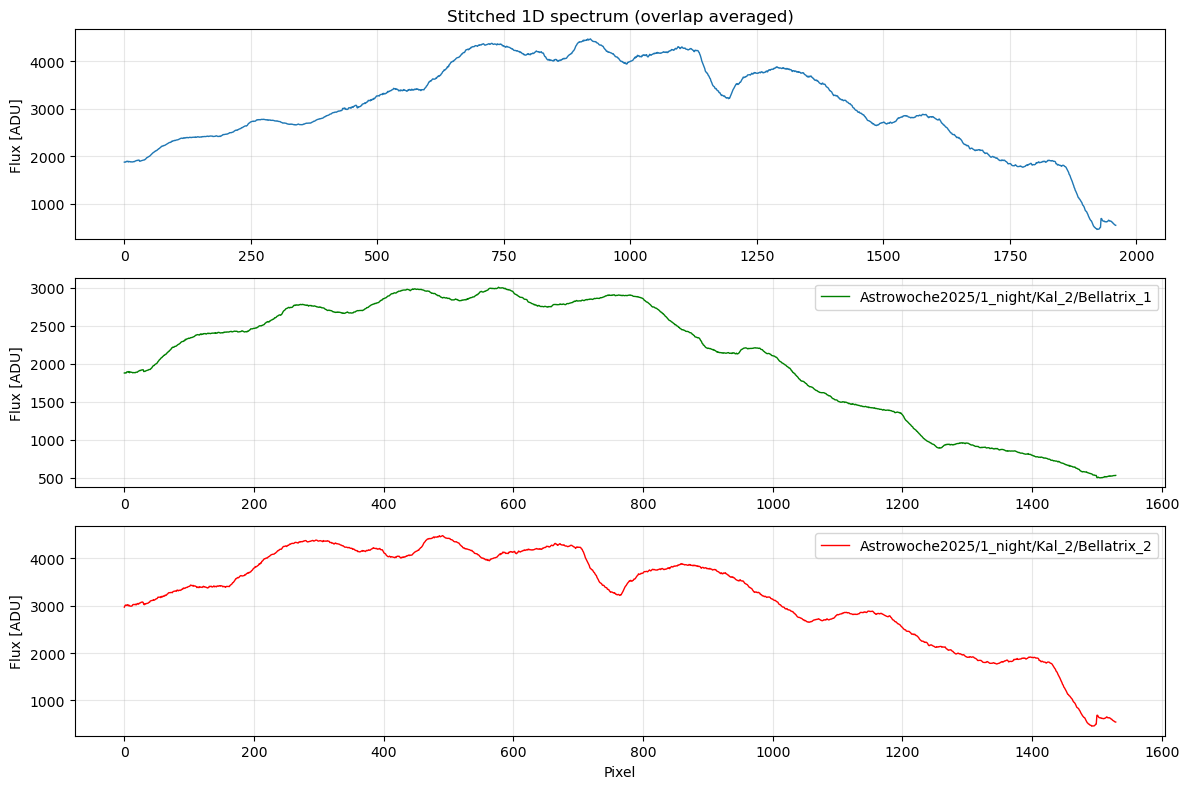

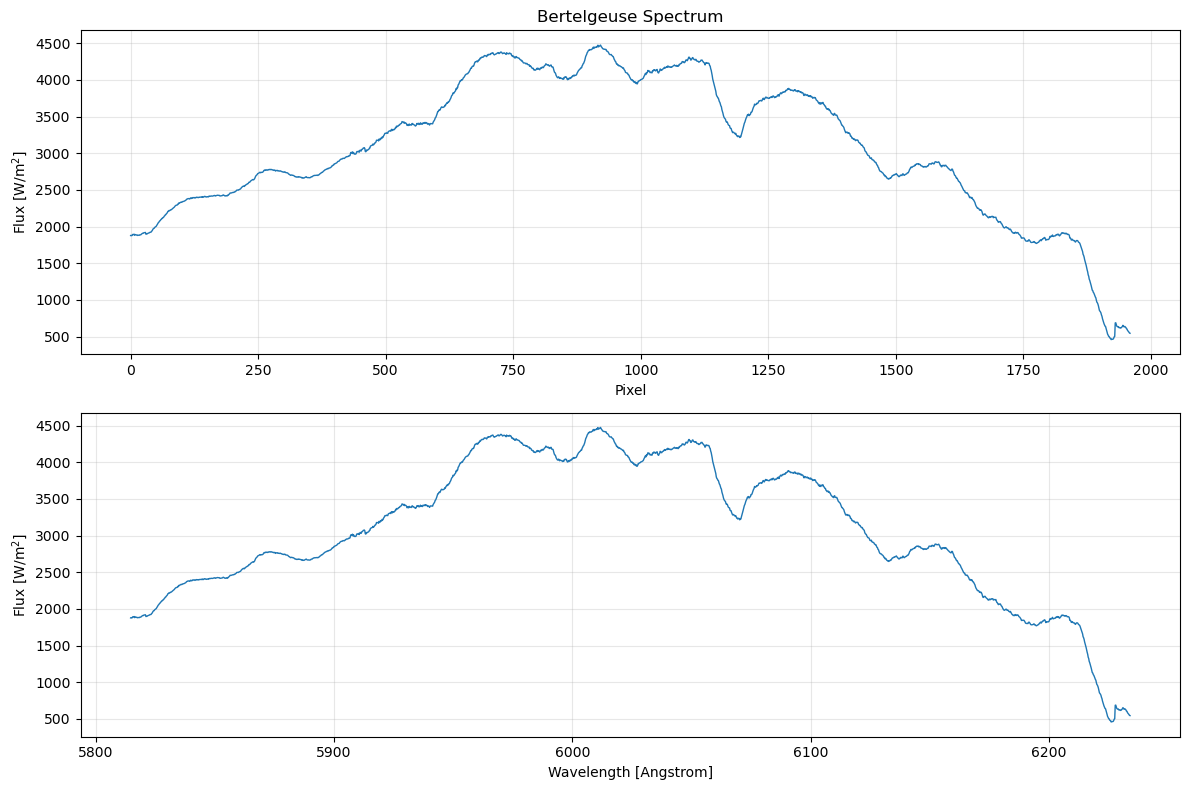

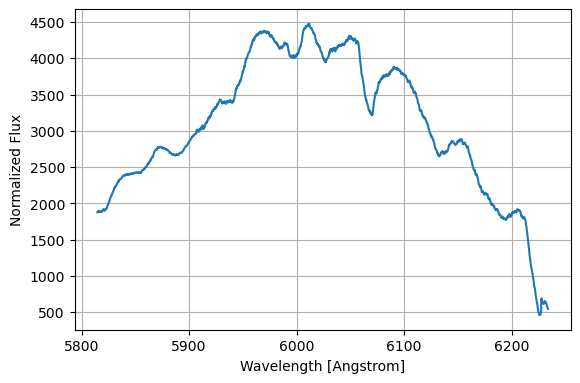

In [128]:
path1 = "Astrowoche2025/1_night/Kal_2/Bellatrix_1"
path2 = "Astrowoche2025/1_night/Kal_2/Bellatrix_2"


x_comb_pollux, s_comb_pollux, *rest = combine_spec(path1, path2, folder1 = True, folder2=True, plot = True, scal= 1, shift = shift_1night_2, filtering = True, delta = 30)
lam_axis_pollux = np.polyval(coeff_night1_2, x_comb_pollux)
plot_spectrum(x_comb_pollux, lam_axis_pollux, s_comb_pollux, "Bertelgeuse Spectrum")



### Bertelgeuse

Astrowoche2025/1_night/Kal_2/Betelgeuse_1\betelgeuse_spec_1.FIT
1530
Astrowoche2025/1_night/Kal_2/Betelgeuse_1\betelgeuse_spec_1_backup.FIT
1530
Astrowoche2025/1_night/Kal_2/Betelgeuse_1\betelgeuse_spec_1_backup_2.FIT
1530
Astrowoche2025/1_night/Kal_2/Betelgeuse_2\betelgeuse_spec_2.FIT
1530
Astrowoche2025/1_night/Kal_2/Betelgeuse_2\betelgeuse_spec_2_backup.FIT
1530
Astrowoche2025/1_night/Kal_2/Betelgeuse_2\betelgeuse_spec_2_backup_2.FIT
1530
1960


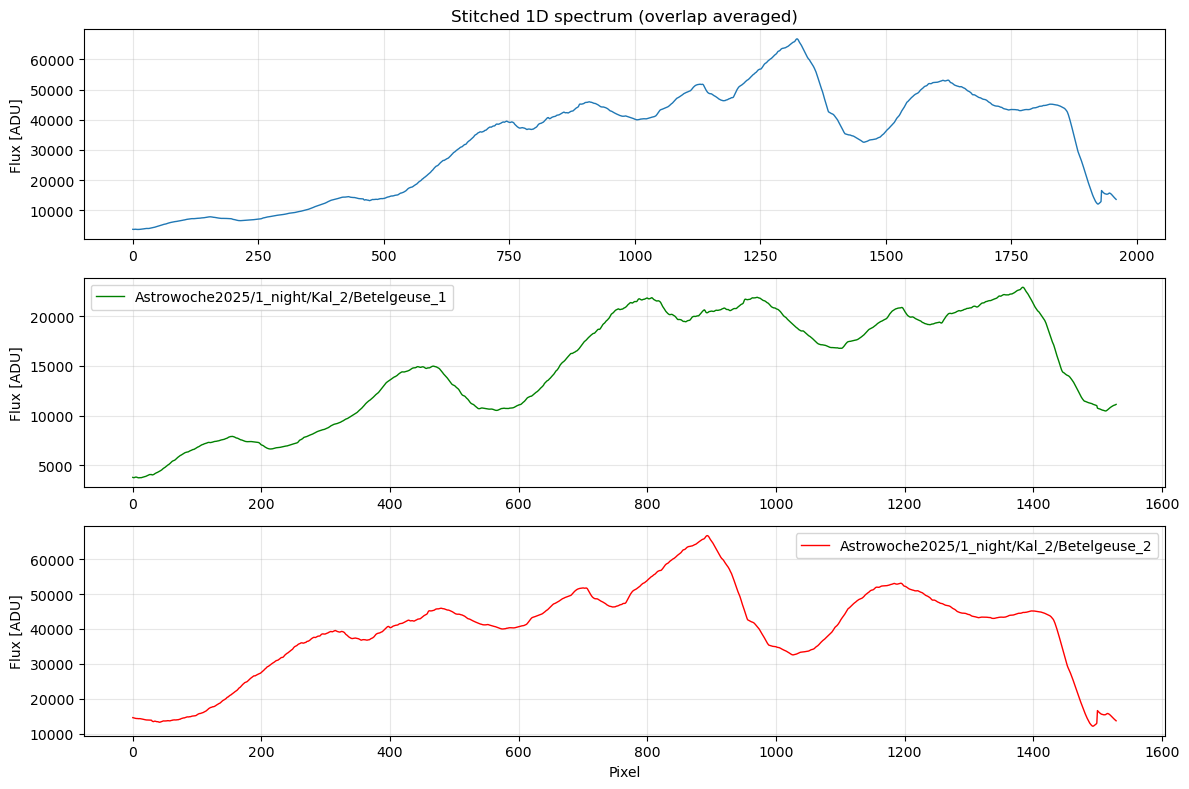

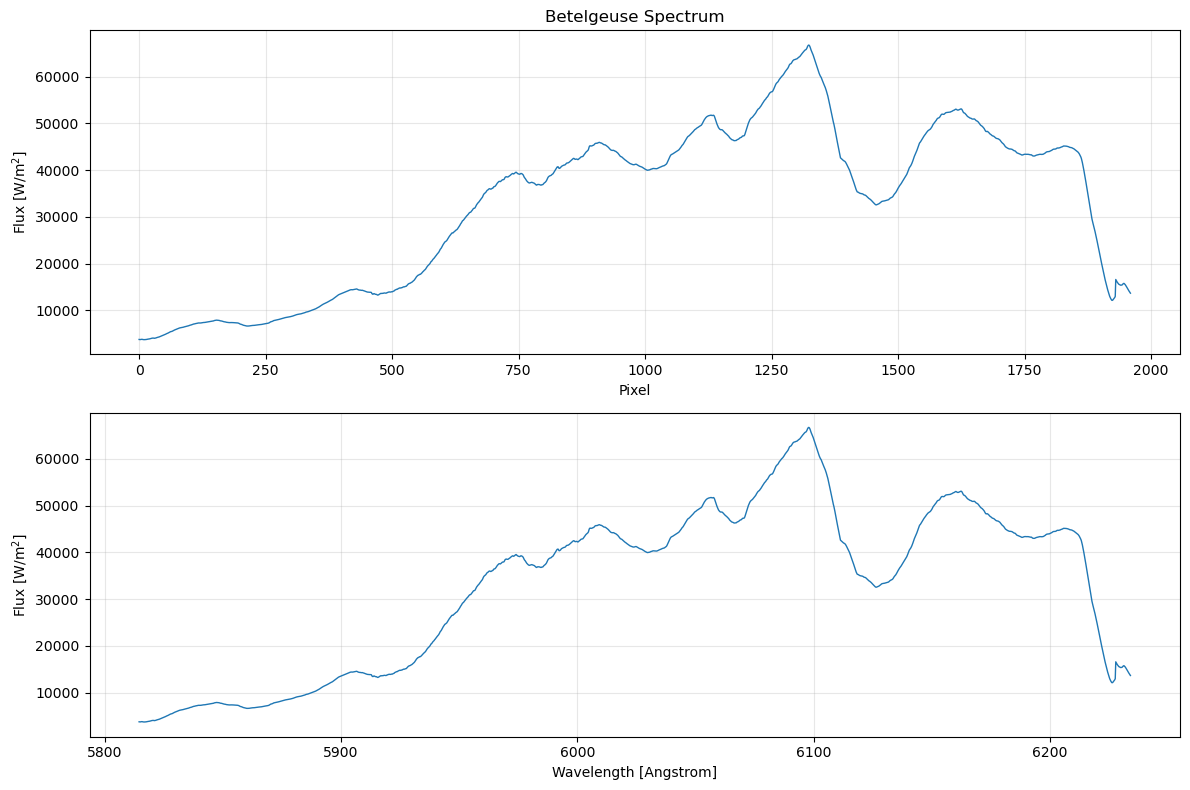

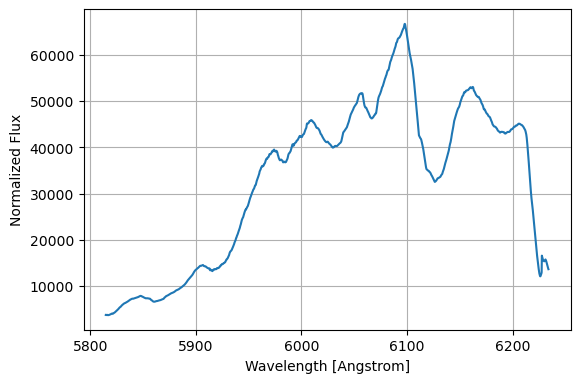

In [129]:
path1 = "Astrowoche2025/1_night/Kal_2/Betelgeuse_1"
path2 = "Astrowoche2025/1_night/Kal_2/Betelgeuse_2"


x_comb_pollux, s_comb_pollux, *rest = combine_spec(path1, path2, folder1 = True, folder2=True, plot = True, scal= 1, shift = shift_1night_2, filtering = True, delta = 30)
lam_axis_pollux = np.polyval(coeff_night1_2, x_comb_pollux)
plot_spectrum(x_comb_pollux, lam_axis_pollux, s_comb_pollux, "Betelgeuse Spectrum")



## 2. Night (zuerst 0_35 messung dann 1_25)

2085


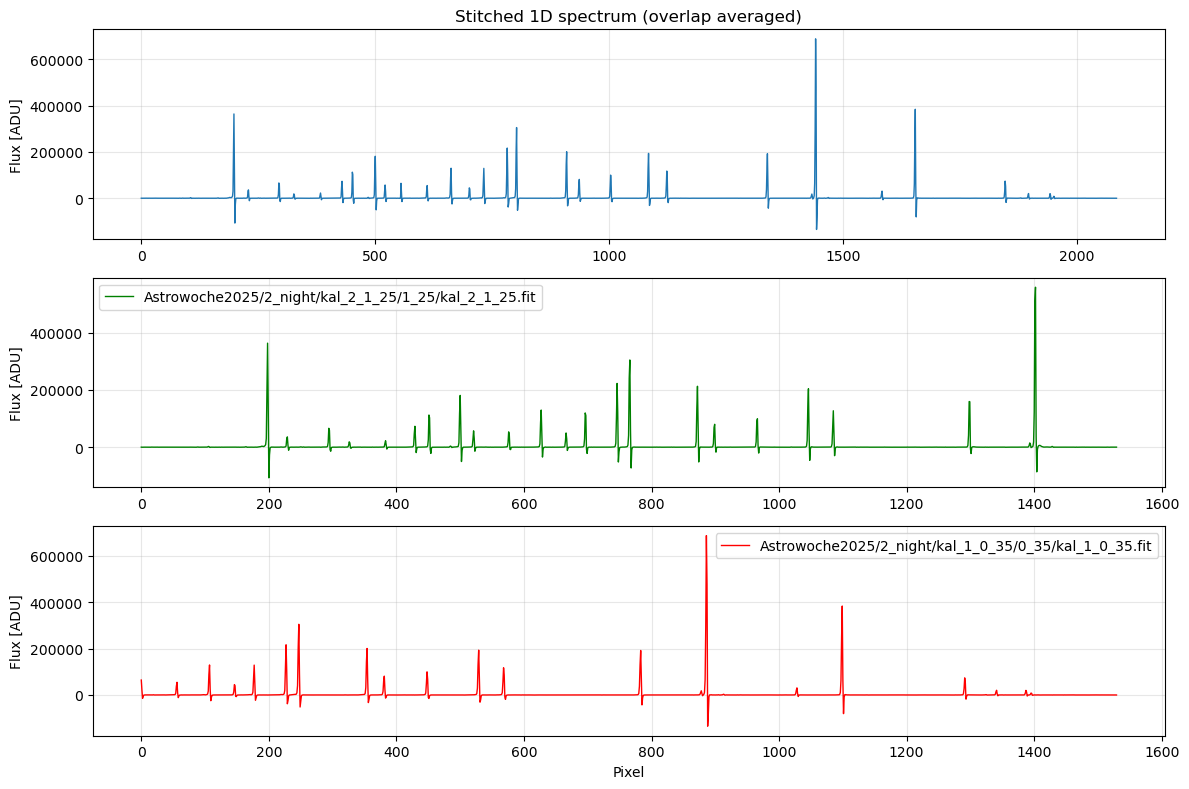

Scal: None
inliers: 12 coeff: [9.76062500e-02 5.83404032e+03]


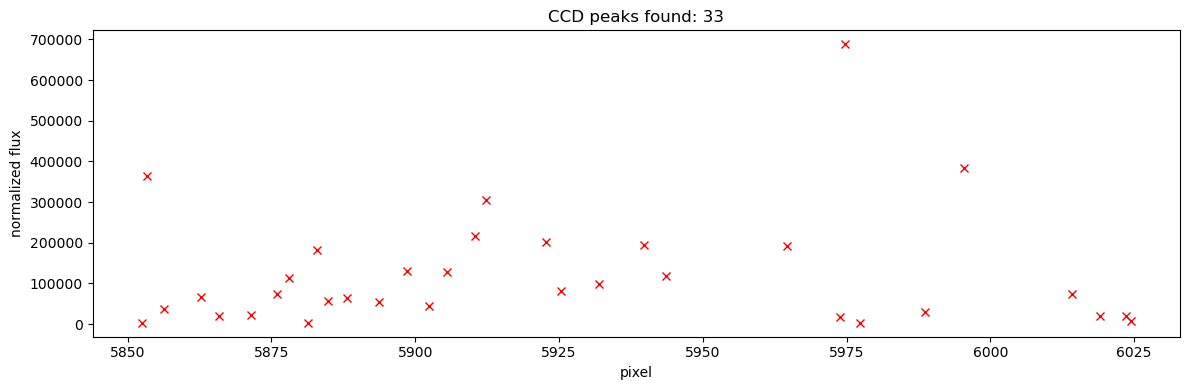

[5852.4879     5853.36635625 5856.39215    5862.73655625 5865.85995625
 5871.4235125  5875.9134     5878.0607375  5881.37935    5882.84344375
 5884.893175   5888.2117875  5893.6777375  5898.65565625 5902.4623
 5905.48809375 5910.36840625 5912.32053125 5922.7644     5925.39976875
 5931.9393875  5939.84549375 5943.6521375  5964.63748125 5973.910075
 5974.690925   5977.32629375 5988.5510125  5995.48105625 6014.22145625
 6019.10176875 6023.59165625 6024.37250625]


In [143]:


path2 = "Astrowoche2025/2_night/kal_1_0_35/0_35/kal_1_0_35.fit"
path1 = "Astrowoche2025/2_night/kal_2_1_25/1_25/kal_2_1_25.fit"


shift_2night = 975
x_comb, s_comb, shift, x1, s1, x2, s2, scal = combine_spec(path1, path2, folder1 = False, folder2 = False, plot = True, shift = shift_2night)

print("Scal:", scal)

ninl, coeff_2night = calibrate_with_anchor(x_comb, s_comb, ref_w, tol=1.5)
print("inliers:", ninl, "coeff:", coeff)

lam_axis = np.polyval(coeff, x_comb)
peaks, props = find_peaks(s_comb,height = 3000)
plt.figure(figsize=(12,4))
plt.plot(lam_axis[peaks] ,s_comb[peaks],  "rx", ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("pixel")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()

print(lam_axis[peaks])


### Deneb

Astrowoche2025/2_night/Deneb_1\deneb_spec_1.FIT
1530
Astrowoche2025/2_night/Deneb_1\deneb_spec_1_backup.FIT
1530
Astrowoche2025/2_night/Deneb_1\deneb_spec_1_backup_2.FIT
1530
Astrowoche2025/2_night/Deneb_2\deneb_spec_2.FIT
1530
Astrowoche2025/2_night/Deneb_2\deneb_spec_2_backup.FIT
1530
Astrowoche2025/2_night/Deneb_2\deneb_spec_2_backup_2.FIT
1530
1960


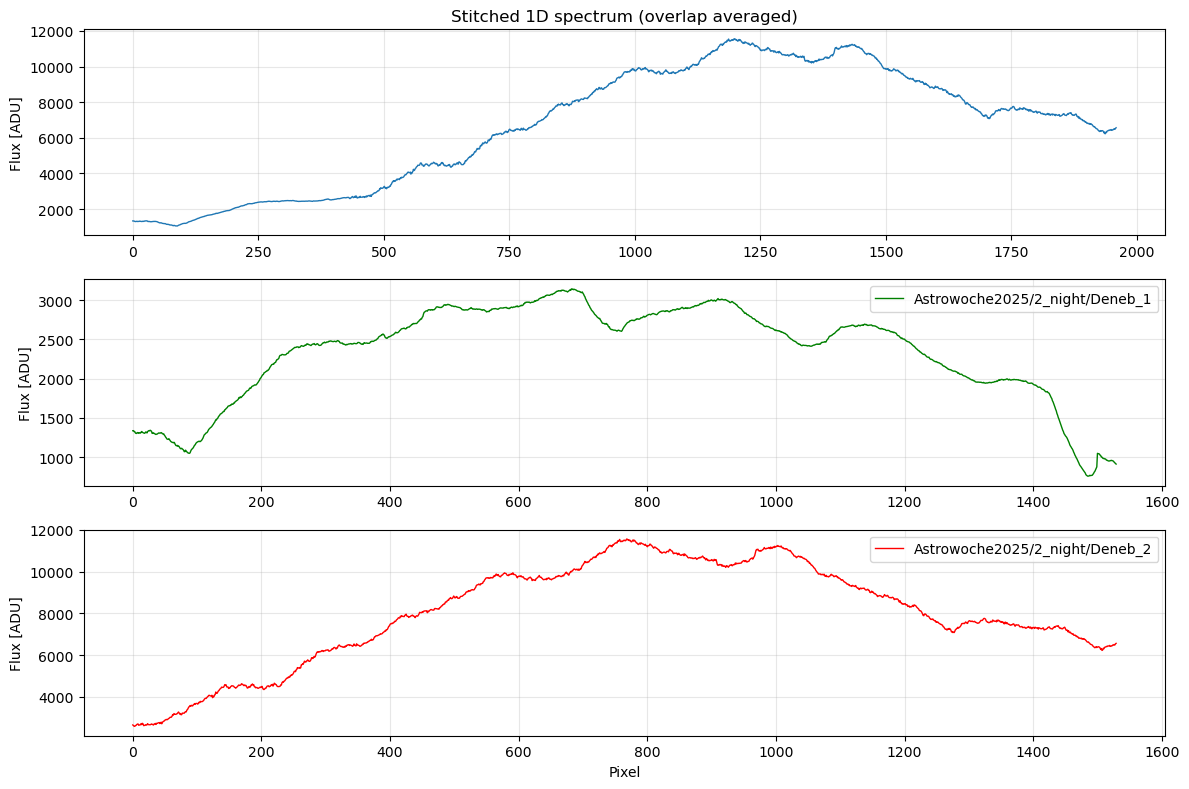

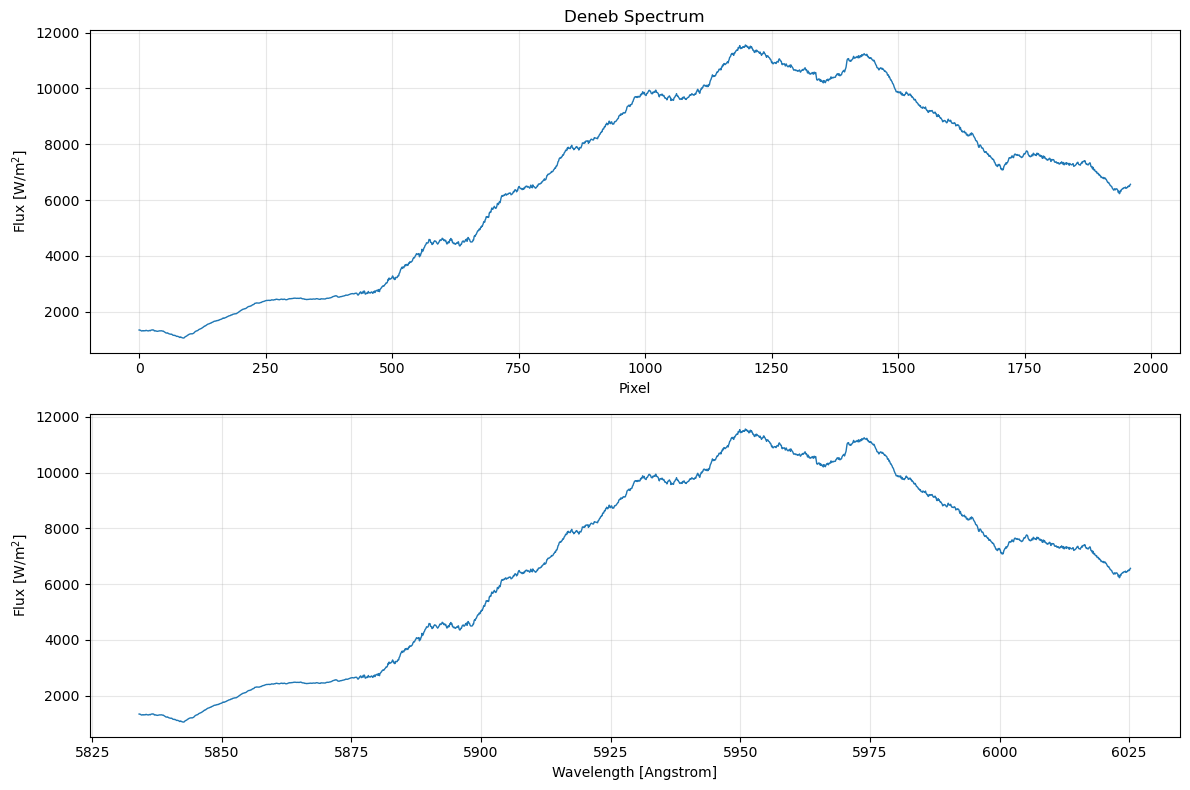

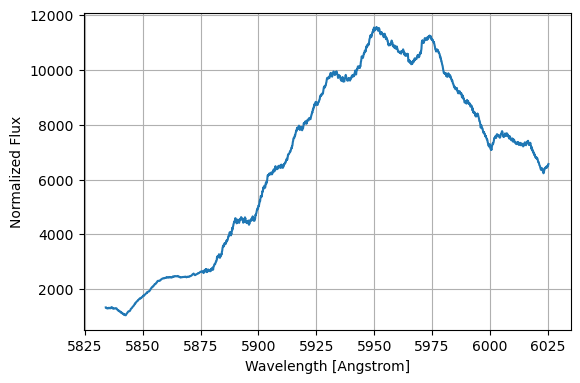

In [145]:
path1 = "Astrowoche2025/2_night/Deneb_1"
path2 = "Astrowoche2025/2_night/Deneb_2"


x_comb_pollux, s_comb_pollux, *rest = combine_spec(path1, path2, folder1 = True, folder2=True, plot = True, scal= 1, shift = shift_1night_2, filtering = True, delta = 30)
lam_axis_pollux = np.polyval(coeff_2night, x_comb_pollux)
plot_spectrum(x_comb_pollux, lam_axis_pollux, s_comb_pollux, "Deneb Spectrum")



### Merak

Astrowoche2025/2_night/Merak_1\merak_spec_1.FIT
1530
Astrowoche2025/2_night/Merak_1\merak_spec_1_backup.FIT
1530
Astrowoche2025/2_night/Merak_2\merak_spec_2.FIT
1530
Astrowoche2025/2_night/Merak_2\merak_spec_2_backup.FIT
1530
Astrowoche2025/2_night/Merak_2\merak_spec_2_backup_2.FIT
1530
1960


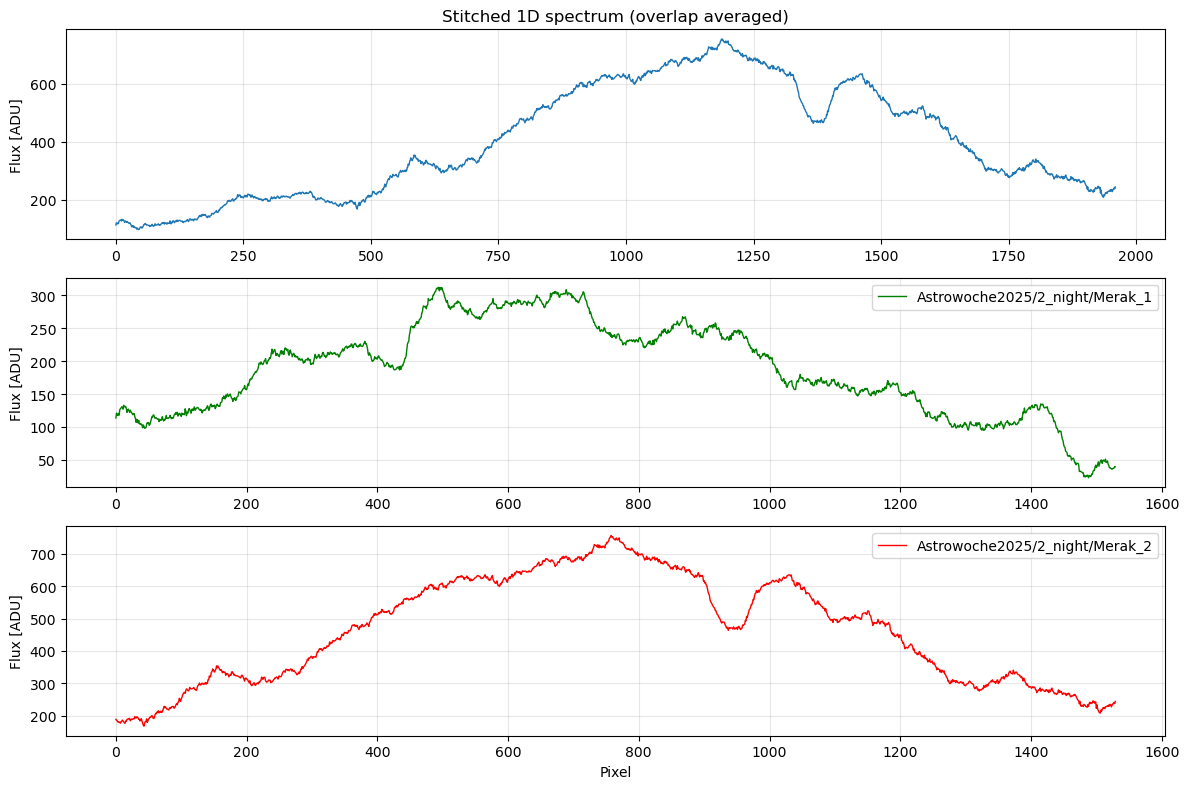

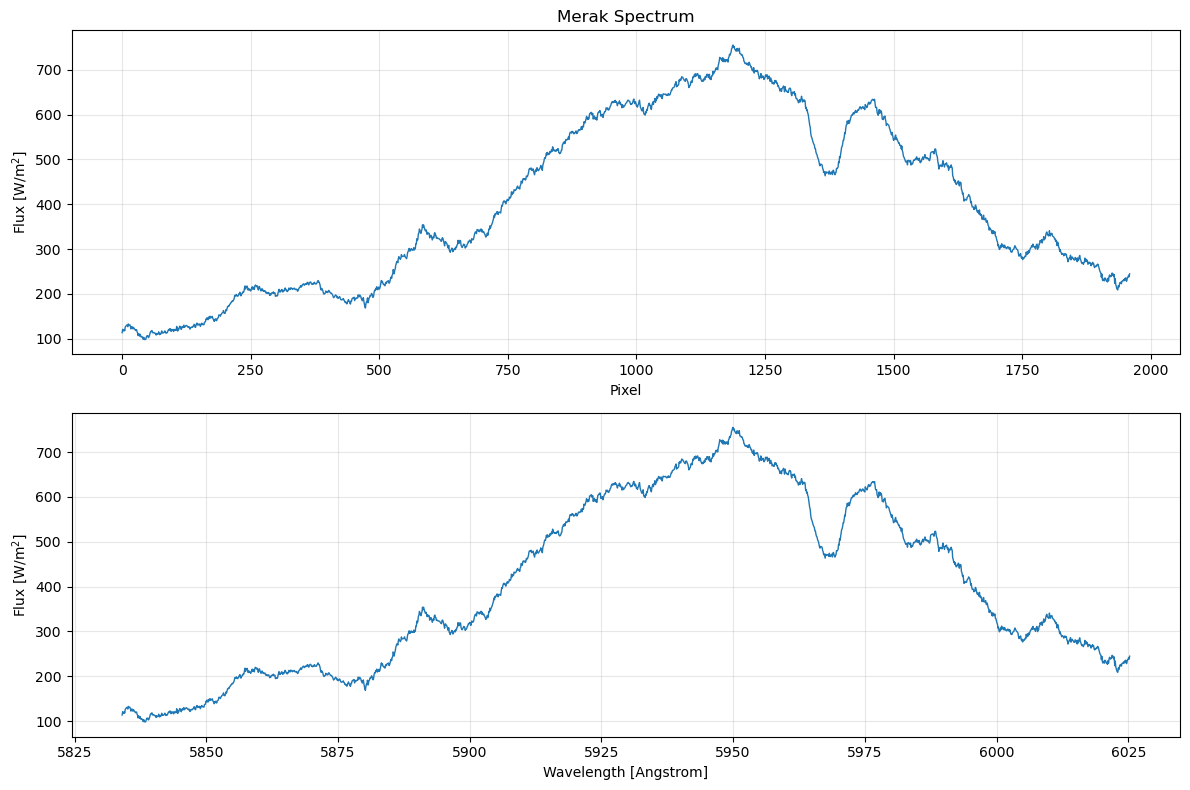

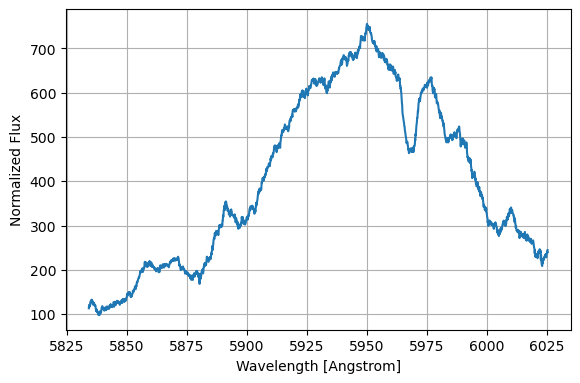

In [146]:
path1 = "Astrowoche2025/2_night/Merak_1"
path2 = "Astrowoche2025/2_night/Merak_2"


x_comb_pollux, s_comb_pollux, *rest = combine_spec(path1, path2, folder1 = True, folder2=True, plot = True, scal= 1, shift = shift_1night_2, filtering = True, delta = 30)
lam_axis_pollux = np.polyval(coeff_2night, x_comb_pollux)
plot_spectrum(x_comb_pollux, lam_axis_pollux, s_comb_pollux, "Merak Spectrum")



### Polaris

## 3. Night
### 1. Round

2660


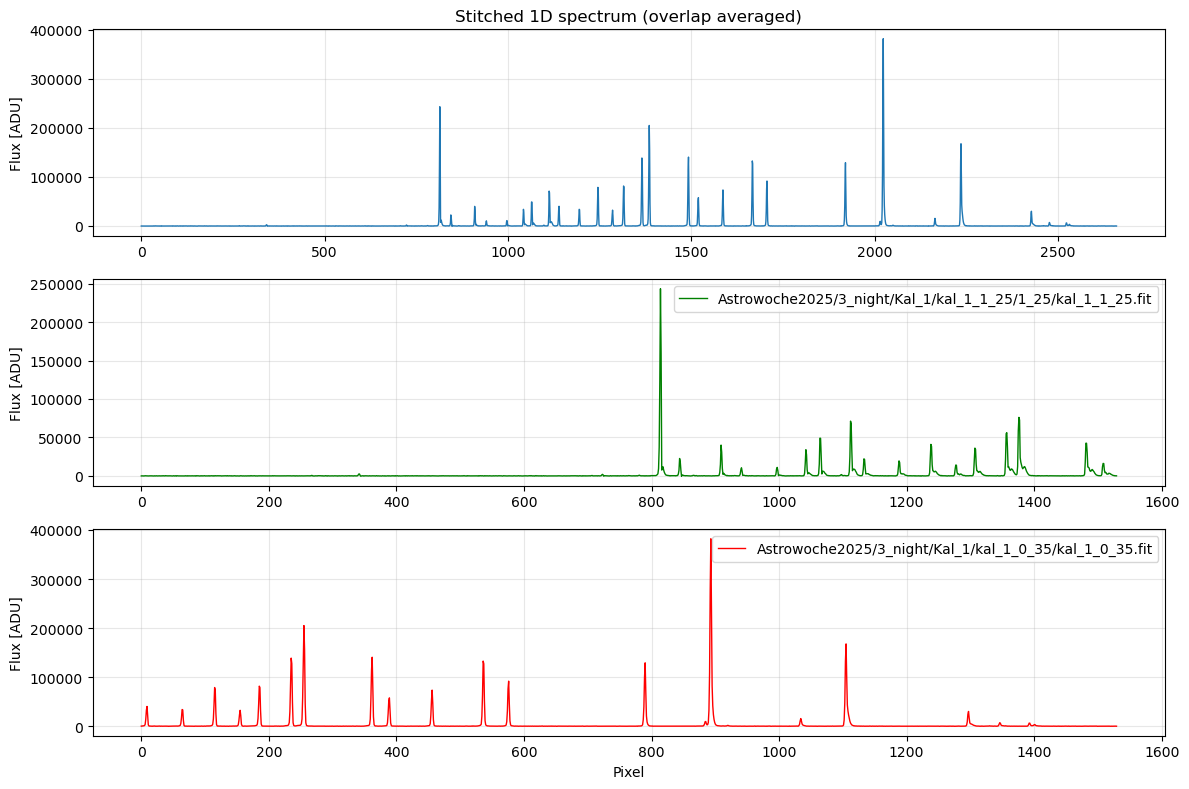

inliers: 13 coeff: [9.61727559e-01 5.06964167e+03]


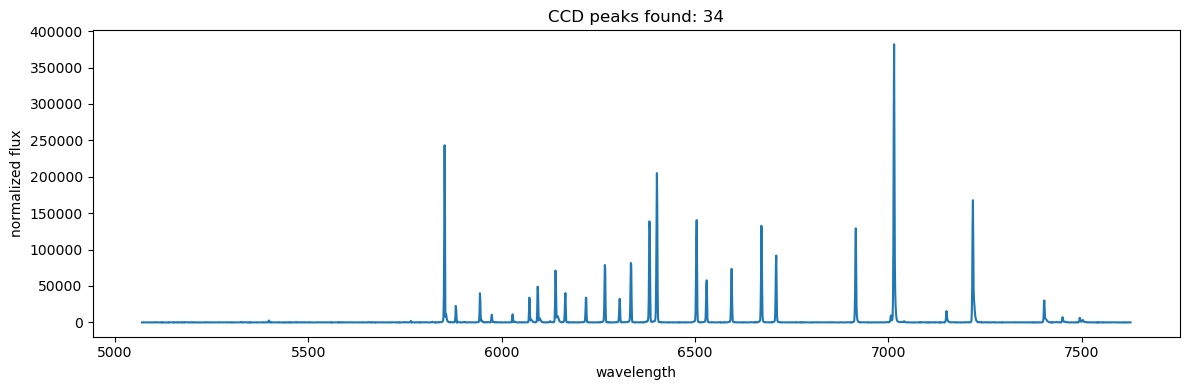

[5852.4879     5856.33481024 5881.33972677 5943.85201811 5947.69892835
 5974.6273     6028.48404331 6071.76178346 6076.57042126 6092.91978976
 6096.7667     6139.0827126  6143.89135039 6165.04935669 6217.94437244
 6266.99247795 6305.46158031 6334.31340709 6382.39978504 6401.63433622
 6504.53918504 6530.50582913 6594.94157559 6671.87978031 6710.34888268
 6916.15858031 7007.52269843 7015.2165189  7150.82010472 7219.10276142
 7403.75445276 7450.87910315 7496.08029843 7503.7741189 ]


In [85]:

path1 = "Astrowoche2025/3_night/Kal_1/kal_1_1_25/1_25/kal_1_1_25.fit"
path2 = "Astrowoche2025/3_night/Kal_1/kal_1_0_35/kal_1_0_35.fit"
shift_3night_1 = 400
x_comb, s_comb, shift, x1, s1, x2, s2, scal_night3_1 = combine_spec(path1, path2, folder1=False, folder2 = False , plot = True, shift = shift_3night_1)




ninl, coeff_night3_1 = calibrate_with_anchor(x_comb, s_comb, ref_w, tol=1.5)
print("inliers:", ninl, "coeff:", coeff_night3_1)

lam_axis = np.polyval(coeff_night3_1, x_comb)
peaks, props = find_peaks(s_comb,height = 3000)
plt.figure(figsize=(12,4))
plt.plot(lam_axis ,s_comb,   ms=6)
plt.title(f"CCD peaks found: {len(peaks)}")
plt.xlabel("wavelength")
plt.ylabel("normalized flux")
plt.tight_layout()
plt.show()

print(lam_axis[peaks])

### Vega

Astrowoche2025/3_night/Kal_1/Vega_1\vega_spec_1.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_1\vega_spec_1_backup.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_1\vega_spec_1_backup_2.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_2\vega_spec_2.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_2\vega_spec_2_backup.FIT
1530
Astrowoche2025/3_night/Kal_1/Vega_2\vega_spec_2_backup_2.FIT
1530
2660


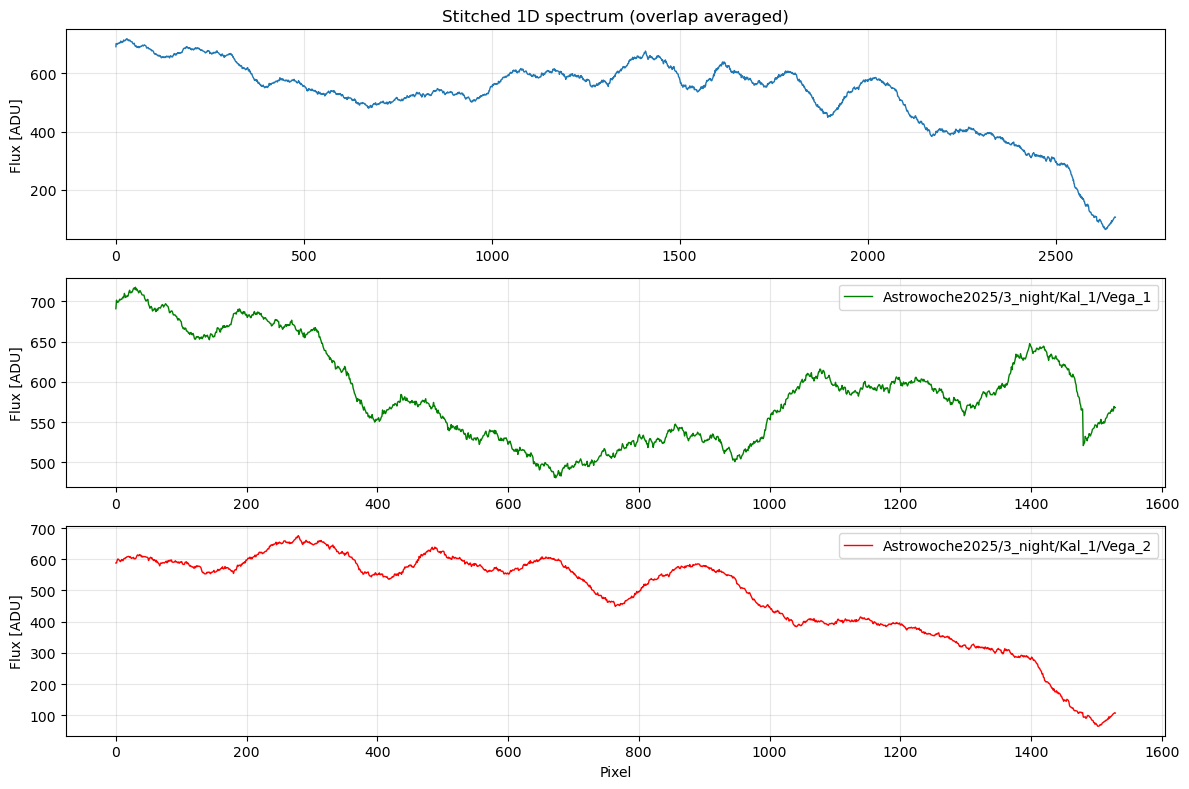

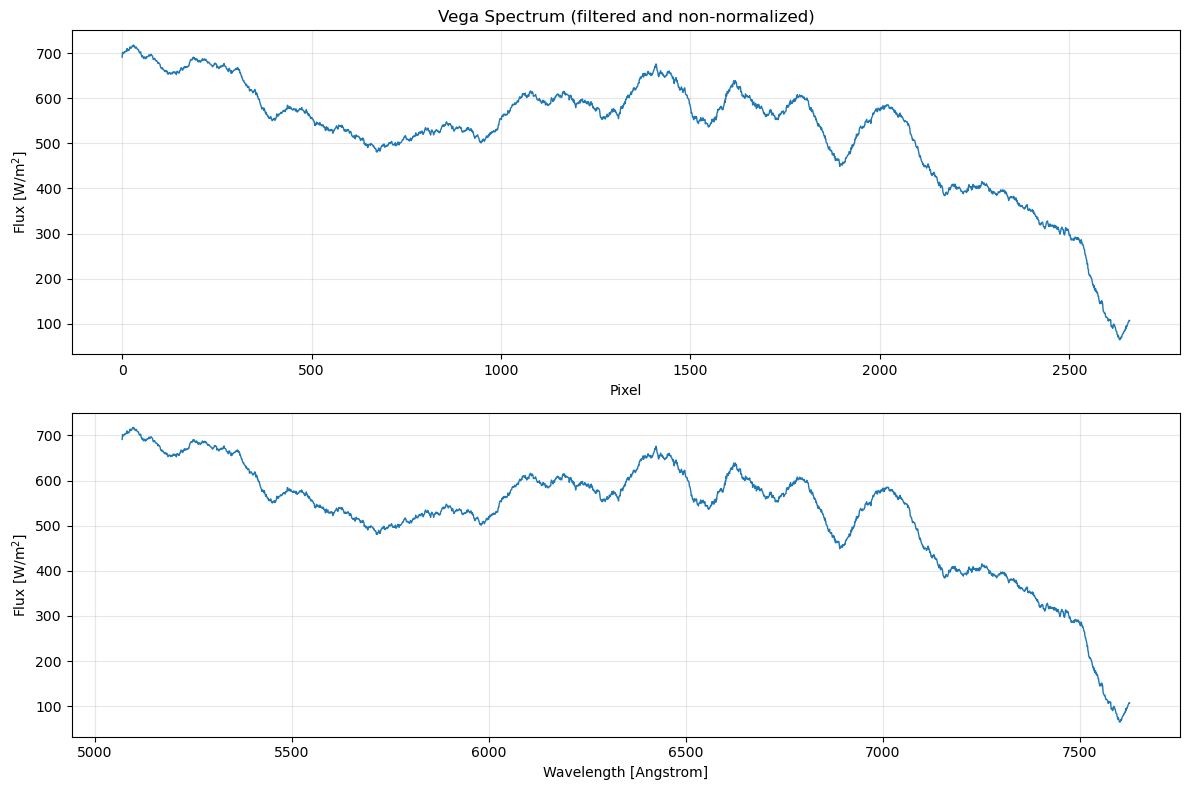

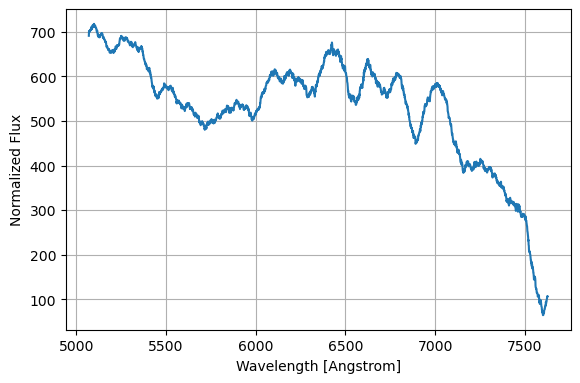

Filename: Astrowoche2025/alpha_lyr_mod_004.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   ()      
  1  SCI           1 BinTableHDU     23   8094R x 3C   [1D, 1E, 1E]   
['WAVELENGTH', 'FLUX', 'CONTINUUM']


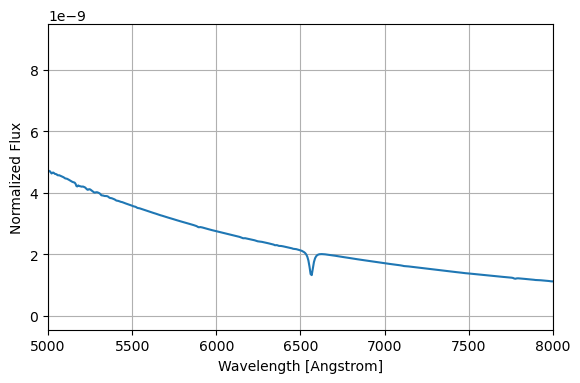

[9.00388727e+02 9.01291391e+02 9.02194936e+02 ... 2.98765844e+06
 2.99065357e+06 2.99365170e+06]


In [101]:
path1 = "Astrowoche2025/3_night/Kal_1/Vega_1"
path2 = "Astrowoche2025/3_night/Kal_1/Vega_2"


x_comb_vega, s_comb_vega, *rest = combine_spec(path1, path2,folder1= True,  folder2 =True,  plot = True, shift = shift_3night_1, scal = 1, filtering = True, normalize = False, delta = 50)
lam_axis_vega = np.polyval(coeff_night3_1, x_comb_vega)
plot_spectrum(x_comb_vega, lam_axis_vega, s_comb_vega, "Vega Spectrum (filtered and non-normalized)")


## Desired Spectrum
from astropy.io import fits

path_vega = "Astrowoche2025/alpha_lyr_mod_004.fits"

fits.info(path_vega)


with fits.open(path_vega) as hdul:
    tab = hdul["SCI"].data          # oder hdul[1].data
    print(tab.names) 

lam_vega  = tab["WAVELENGTH"]   # Beispielname
flux_vega = tab["FLUX"]


cm = 1/2.54
plt.figure(figsize=(15*cm,10*cm))
plt.plot(lam_vega, flux_vega)
plt.xlim(5000, 8000)
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Normalized Flux")
plt.tight_layout()
plt.grid()
plt.show()

print(lam_vega)


2660


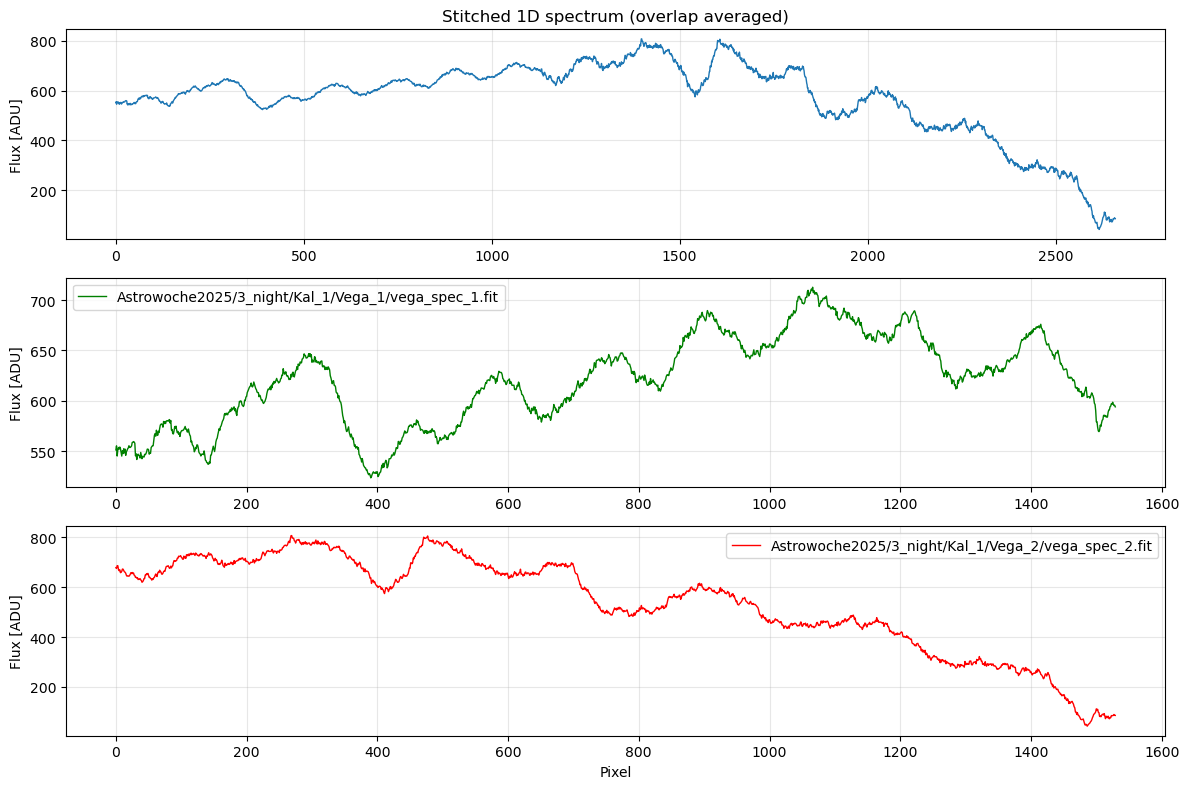

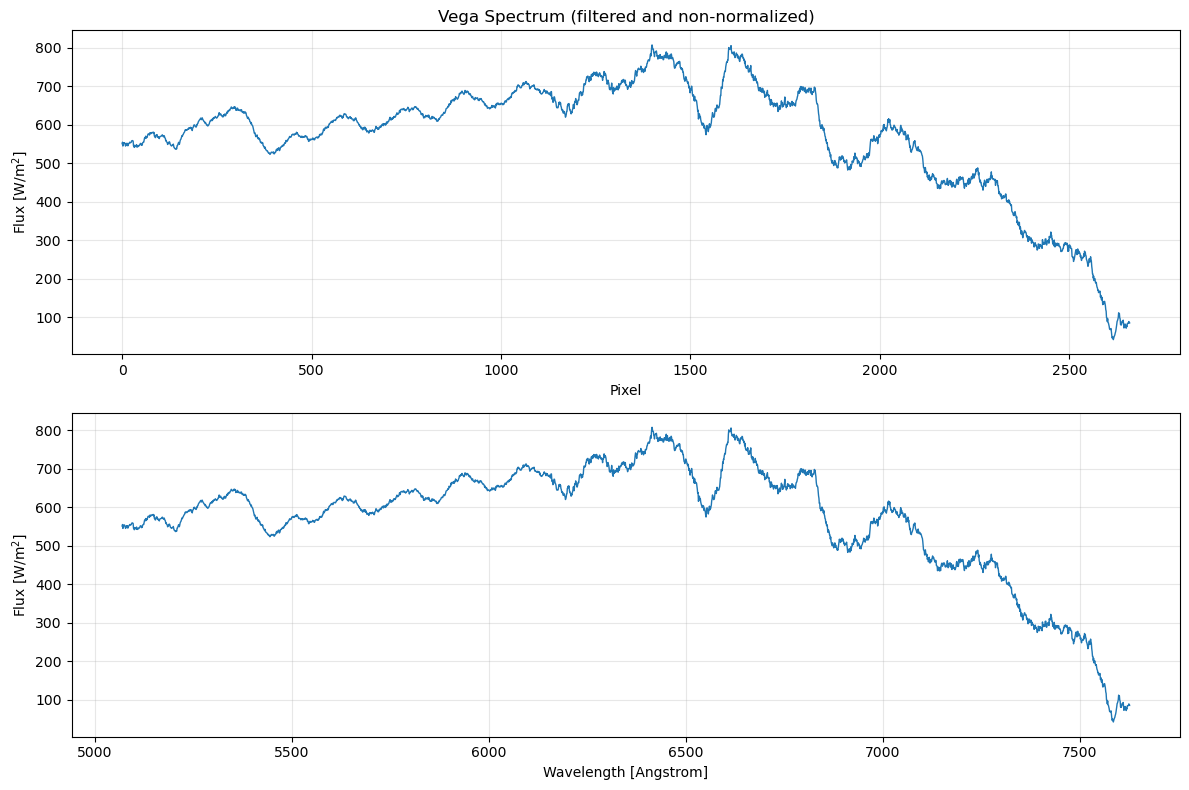

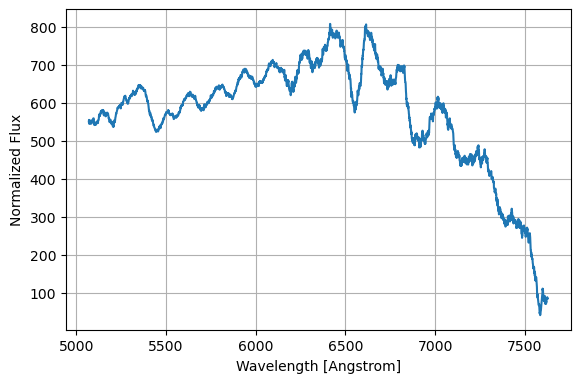

In [90]:
path1 = "Astrowoche2025/3_night/Kal_1/Vega_1/vega_spec_1.fit"
path2 = "Astrowoche2025/3_night/Kal_1/Vega_2/vega_spec_2.fit"


x_comb_vega, s_comb_vega, *rest = combine_spec(path1, path2,folder1= False,  folder2 =False,  plot = True, shift = shift_3night_1, scal = 1, filtering = True, normalize = False, delta = 30)
lam_axis_vega = np.polyval(coeff_night3_1, x_comb_vega)
plot_spectrum(x_comb_vega, lam_axis_vega, s_comb_vega, "Vega Spectrum (filtered and non-normalized)")